# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef as phi_coef
import json
from torch import save, load

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [3]:
seed = 2609612152#randint(0, 4294967295) #60412887
print(seed)

2609612152


In [4]:
DIR = 'heart'

In [5]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure',
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv(f'data/{DIR}/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
0  70.0  1.0         4.0           130.0        322.0          0.0   
1  67.0  0.0         3.0           115.0        564.0          0.0   
2  57.0  1.0         2.0           124.0        261.0          0.0   
3  64.0  1.0         4.0           128.0        263.0          0.0   
4  74.0  0.0         2.0           120.0        269.0          0.0   

   eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
0             2.0           109.0          0.0      2.4         2.0   
1             2.0           160.0          0.0      1.6         2.0   
2             0.0           141.0          0.0      0.3         1.0   
3             0.0           105.0          1.0      0.2         2.0   
4             2.0           121.0          1.0      0.2         1.0   

   major_vessels  thal  target  
0            3.0   3.0       1  
1            0.0   7.0       0  
2            0.0   7.0       1  
3            1.0   7.0       0  
4            1.0   3.0       0

<Axes: >

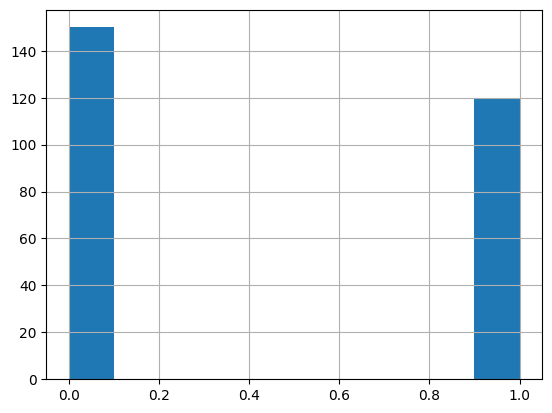

In [6]:
df['target'].hist()

<Axes: >

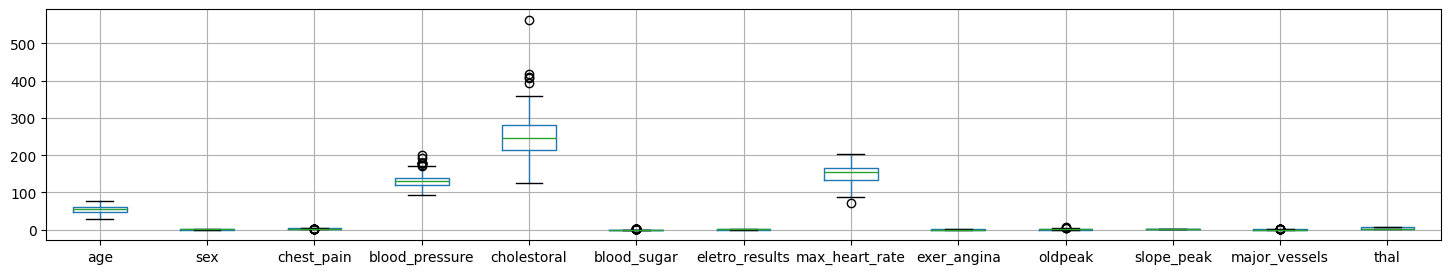

In [7]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

In [8]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

<Axes: >

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [9]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [10]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [11]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [12]:
performs = {}
models_error = pd.DataFrame()
models = []

In [13]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0],
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0],
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [14]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30],
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60],
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8404
Recall:           0.9362
Precision:        0.7857
F1:               0.8544
AUROC:            0.9108
AUPR:             0.8889
1-maxProb média:  0.1596
1-maxProb dp:     0.1609

[Testing]

Accuracy:         0.7474
Recall:           0.9459
Precision:        0.6140
F1:               0.7447
AUROC:            0.8318
AUPR:             0.6766
1-maxProb média:  0.1787
1-maxProb dp:     0.1596


In [16]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.357143
1  0.965517
2  0.357143
3  0.461538
4  0.078947

In [17]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [18]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [19]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.8936
Recall:           0.8511
Precision:        0.9302
F1:               0.8889
AUROC:            0.9670
AUPR:             0.9704
1-maxProb média:  0.1241
1-maxProb dp:     0.1313

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8700
AUPR:             0.7426
1-maxProb média:  0.1531
1-maxProb dp:     0.1398


### Logistic Regression

In [20]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [21]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.8723
Recall:           0.8298
Precision:        0.9070
F1:               0.8667
AUROC:            0.9593
AUPR:             0.9632
1-maxProb média:  0.1991
1-maxProb dp:     0.1231

[Testing]

Accuracy:         0.8000
Recall:           0.7838
Precision:        0.7250
F1:               0.7532
AUROC:            0.8914
AUPR:             0.8023
1-maxProb média:  0.2386
1-maxProb dp:     0.1275


### K-Nearest Neighbors

(KNN)

In [22]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}


In [23]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.8617
Recall:           0.7872
Precision:        0.9250
F1:               0.8506
AUROC:            0.9350
AUPR:             0.9311
1-maxProb média:  0.1996
1-maxProb dp:     0.1341

[Testing]

Accuracy:         0.8421
Recall:           0.7838
Precision:        0.8056
F1:               0.7945
AUROC:            0.9091
AUPR:             0.8460
1-maxProb média:  0.2198
1-maxProb dp:     0.1426


### Support Vector Machine - Linear
(SVM)

In [24]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [25]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9588
AUPR:             0.9610
1-maxProb média:  0.1726
1-maxProb dp:     0.1209

[Testing]

Accuracy:         0.7474
Recall:           0.7838
Precision:        0.6444
F1:               0.7073
AUROC:            0.8681
AUPR:             0.7761
1-maxProb média:  0.2227
1-maxProb dp:     0.1389


### Support Vector Machine - Polynomial
(SVM)

In [26]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [27]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9362
Precision:        0.9778
F1:               0.9565
AUROC:            0.9923
AUPR:             0.9932
1-maxProb média:  0.1359
1-maxProb dp:     0.1205

[Testing]

Accuracy:         0.7474
Recall:           0.7297
Precision:        0.6585
F1:               0.6923
AUROC:            0.8476
AUPR:             0.6949
1-maxProb média:  0.2237
1-maxProb dp:     0.1472


### Support Vector Machine - RBF
(SVM)

In [28]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [29]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.9362
Recall:           0.9362
Precision:        0.9362
F1:               0.9362
AUROC:            0.9896
AUPR:             0.9901
1-maxProb média:  0.1207
1-maxProb dp:     0.0916



[Testing]

Accuracy:         0.7895
Recall:           0.8108
Precision:        0.6977
F1:               0.7500
AUROC:            0.9035
AUPR:             0.8677
1-maxProb média:  0.2082
1-maxProb dp:     0.1550


### Multi-Layer Perceptron
(MLP)

In [30]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'sgd'}


In [31]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9255
Recall:           0.9149
Precision:        0.9348
F1:               0.9247
AUROC:            0.9846
AUPR:             0.9856
1-maxProb média:  0.1262
1-maxProb dp:     0.1304

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8774
AUPR:             0.7919
1-maxProb média:  0.1676
1-maxProb dp:     0.1431


### Kolmogorov-Arnold Network
(KAN)

In [32]:
kan_cv = 0#int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [33]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open(f'kan_params/{DIR}.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/DIR.pkl')
    save(kanet.state_dict(), f'kan_params/{DIR}.pt')
else:
    with open(f'kan_params/{DIR}.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']

    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load(f'kan_params/{DIR}.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[13, 0], [20, 0], [2, 0]],
grid: 6,
lr: 0.001,
lamb: 0.005


In [34]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0154
1-maxProb dp:     0.0273

[Testing]

Accuracy:         0.7684
Recall:           0.8378
Precision:        0.6596
F1:               0.7381
AUROC:            0.8080
AUPR:             0.6027
1-maxProb média:  0.0655
1-maxProb dp:     0.1232


### Random Forest

In [35]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30],
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60],
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


In [36]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9362
Recall:           0.8936
Precision:        0.9767
F1:               0.9333
AUROC:            0.9923
AUPR:             0.9929
1-maxProb média:  0.1925
1-maxProb dp:     0.1323

[Testing]

Accuracy:         0.8211
Recall:           0.7838
Precision:        0.7632
F1:               0.7733
AUROC:            0.9017
AUPR:             0.8420
1-maxProb média:  0.2610
1-maxProb dp:     0.1363


### Gradient Boosting

In [37]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30],
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60],
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 20}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [38]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9681
Recall:           0.9787
Precision:        0.9583
F1:               0.9684
AUROC:            0.9975
AUPR:             0.9974
1-maxProb média:  0.2018
1-maxProb dp:     0.1140

[Testing]

Accuracy:         0.7684
Recall:           0.8919
Precision:        0.6471
F1:               0.7500
AUROC:            0.8956
AUPR:             0.8451
1-maxProb média:  0.2475
1-maxProb dp:     0.1244


### AdaBoost

In [39]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.01, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [40]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9502
AUPR:             0.9546
1-maxProb média:  0.3547
1-maxProb dp:     0.0709

[Testing]

Accuracy:         0.8316
Recall:           0.8649
Precision:        0.7442
F1:               0.8000
AUROC:            0.9087
AUPR:             0.8530
1-maxProb média:  0.3811
1-maxProb dp:     0.0719


### XGBoost

In [41]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


In [42]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0669
1-maxProb dp:     0.0678

[Testing]

Accuracy:         0.8421
Recall:           0.9459
Precision:        0.7292
F1:               0.8235
AUROC:            0.9073
AUPR:             0.8586
1-maxProb média:  0.1401
1-maxProb dp:     0.1385


## Análise de Correlações

In [43]:
groups = {}
model_names = list(performs.keys())

In [44]:
ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):

    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


In [45]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessors Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, DIR)

            corr
count  78.000000
mean    0.609434
std     0.100287
min     0.377330
25%     0.546813
50%     0.610750
75%     0.662262
max     0.858455


[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

kendall:

In [46]:
MIN_SCORE = 0.725 #corrls_values['corr'].quantile(0.85)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.725


[['rforest'],
 ['gb', 'xgb'],
 ['knn', 'lr'],
 ['mlp', 'lr', 'sgd', 'svm_linear'],
 ['mlp', 'svm_rbf', 'lr', 'svm_linear'],
 ['adab'],
 ['kan'],
 ['svm_poly'],
 ['dtree']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [47]:
model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.357143  0.240465  0.416048  0.470588    0.434321  0.412274  0.464318   
1  0.965517  0.646876  0.452941  0.294118    0.563983  0.699817  0.540896   
2  0.357143  0.733488  0.680125  0.705882    0.781501  0.454220  0.602347   
3  0.461538  0.050179  0.282246  0.411765    0.283095  0.363057  0.428255   
4  0.078947  0.607804  0.476185  0.352941    0.456514  0.520778  0.484935   

        mlp       kan   rforest        gb      adab       xgb  
0  0.306677  0.257097  0.347436  0.327406  0.453882  0.491934  
1  0.632825  0.674116  0.401496  0.724044  0.515561  0.846597  
2  0.485079  0.994194  0.652796  0.568036  0.561110  0.480499  
3  0.226214  0.000329  0.297672  0.193701  0.320892  0.085934  
4  0.622468  0.999975  0.287918  0.496492  0.330144  0.461939

In [48]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)

    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.034483  0.113134  0.205486  0.176471    0.147096  0.283670  0.074810   
1  0.034483  0.076642  0.172552  0.176471    0.186982  0.183808  0.101105   
2  0.921053  0.799683  0.663781  0.764706    0.714991  0.651247  0.874132   
3  0.921053  0.730773  0.514733  0.529412    0.500000  0.547081  0.493951   
4  0.461538  0.382534  0.572602  0.705882    0.445445  0.395322  0.513044   

        mlp       kan   rforest        gb      adab       xgb  
0  0.070668  0.000156  0.160674  0.151149  0.419960  0.028248  
1  0.082249  0.000785  0.226245  0.138091  0.261789  0.028824  
2  0.740503  0.997724  0.731392  0.794905  0.669856  0.924587  
3  0.571163  0.999630  0.652502  0.752282  0.580379  0.899618  
4  0.476932  0.883124  0.733779  0.602173  0.453933  0.751114

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

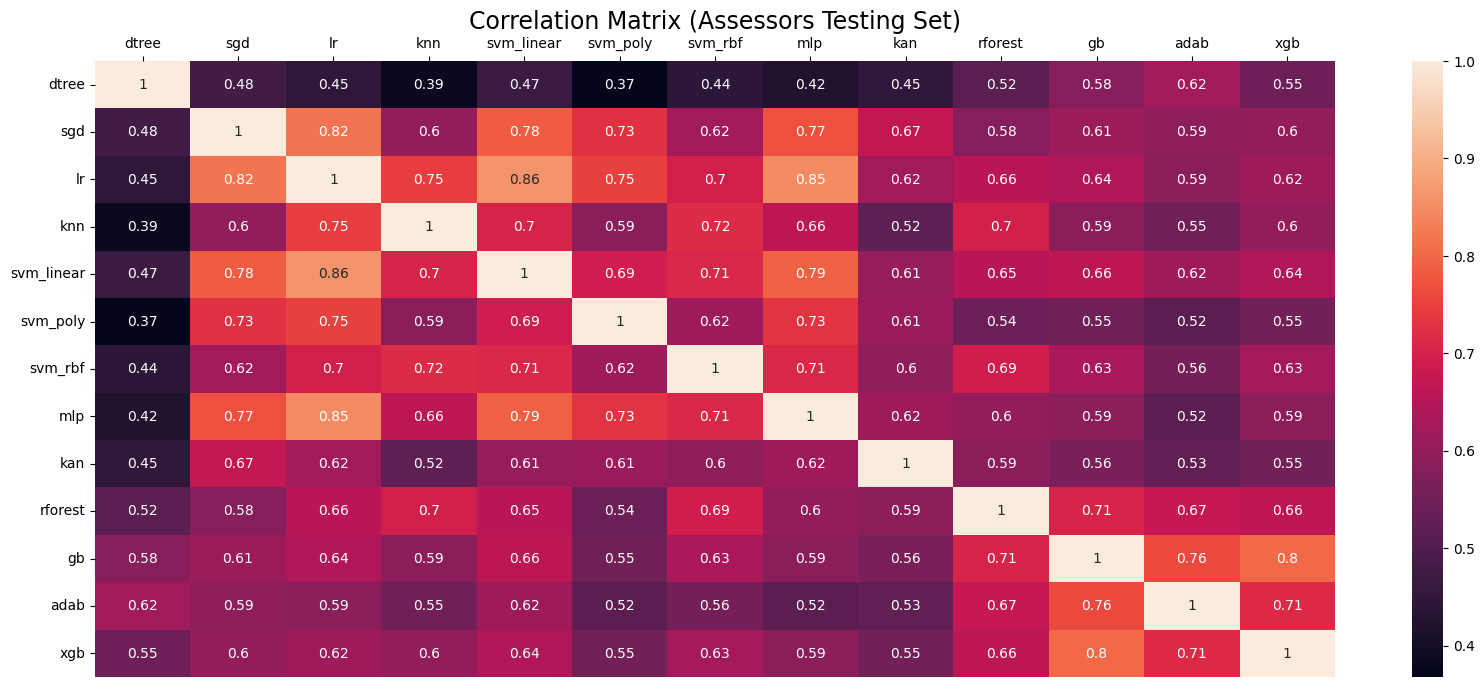

count    78.000000
mean      0.622397
std       0.102396
min       0.367693
25%       0.557593
50%       0.616455
75%       0.694703
max       0.860494
Name: corr, dtype: float64


[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [49]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessors Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [50]:
#MIN_SCORE2 = corrls_values2.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

Min_score: 0.725


[['rforest'],
 ['adab', 'gb'],
 ['gb', 'xgb'],
 ['knn', 'lr'],
 ['sgd', 'mlp', 'svm_poly', 'lr'],
 ['sgd', 'mlp', 'lr', 'svm_linear'],
 ['svm_rbf'],
 ['kan'],
 ['dtree']]

        [['dtree'],
        ['lr', 'mlp', 'sgd', 'svm_linear'],
        ['lr', 'mlp', 'sgd', 'svm_poly'],
        ['knn', 'lr'],
        ['svm_rbf'],
        ['kan'],
        ['rforest'],
        ['adab', 'gb'],
        ['gb', 'xgb']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0015
NMSE: 0.0389
MAE: 0.0299
NMSE: 0.1508


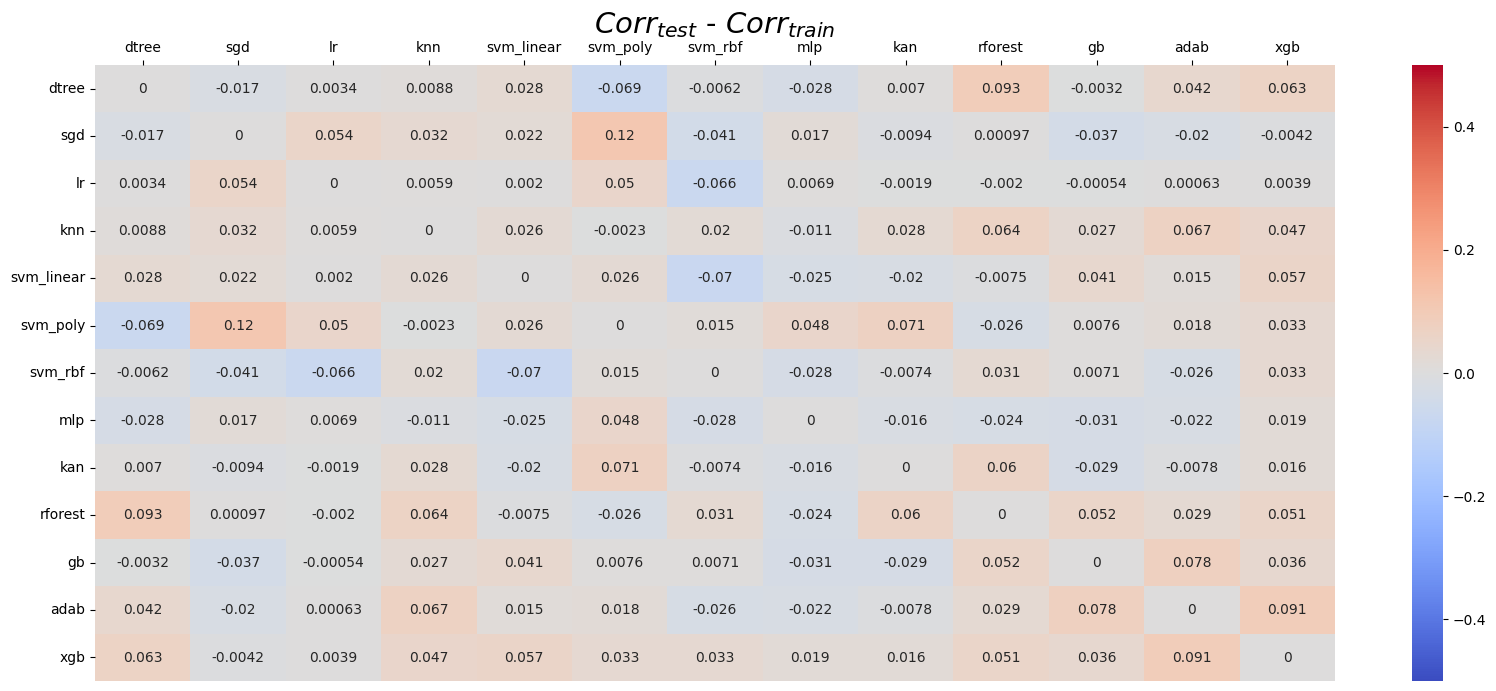

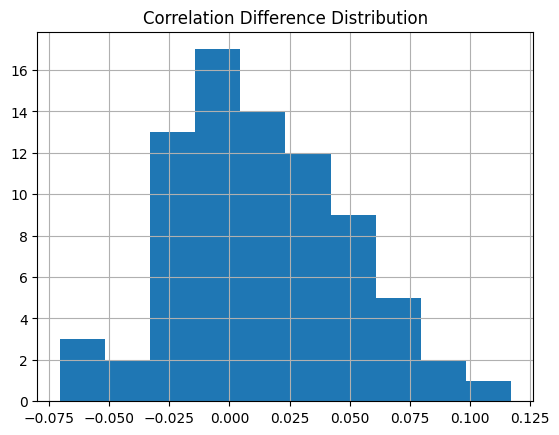

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [51]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
# não adicionar isso em um eventual dataframe de métricas!
# isso é só para ter uma ideia da diferença das relações de erro
# conjunto de treinamento e teste. Não tem nada a ver com assessores
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

### Regressor Chain
(RC)

In [52]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


In [53]:
mse_df = pd.DataFrame(columns=model_names, dtype=float)
#rmse_df = pd.DataFrame(columns=model_names, dtype=float)
nmse_df = pd.DataFrame(columns=model_names, dtype=float)
mae_df = pd.DataFrame(columns=model_names, dtype=float)
nmae_df = pd.DataFrame(columns=model_names, dtype=float)

In [54]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred)}''')

mse_df.loc['regchain',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['regchain',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['regchain',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['regchain',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0662
NMSE: 1.0059
MAE: 0.1929
NMAE: 0.9307659981537151


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain  0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   

           svm_rbf       mlp       kan   rforest        gb      adab       xgb  
regchain  0.056144  0.074294  0.141202  0.039815  0.051366  0.014063  0.105586

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

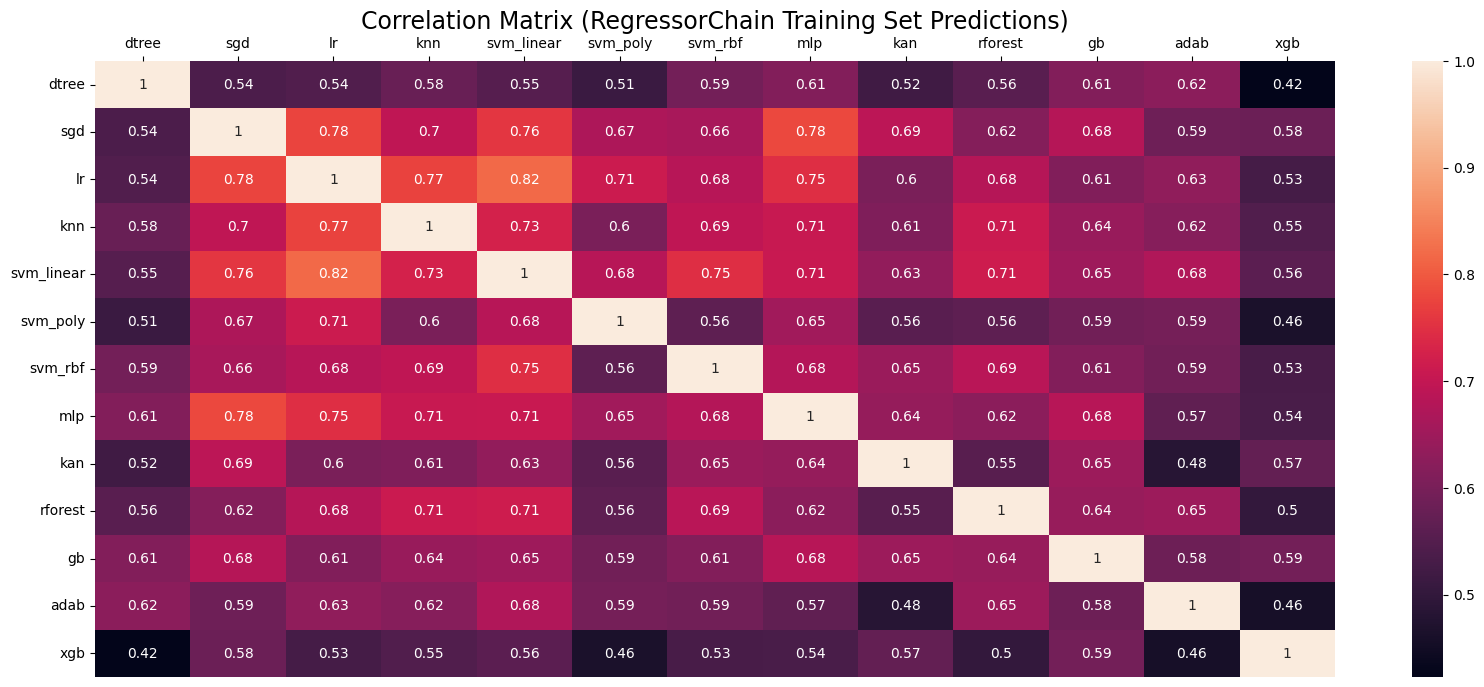

count    78.000000
mean      0.623572
std       0.080524
min       0.422892
25%       0.564502
50%       0.616944
75%       0.682419
max       0.819037
Name: corr, dtype: float64


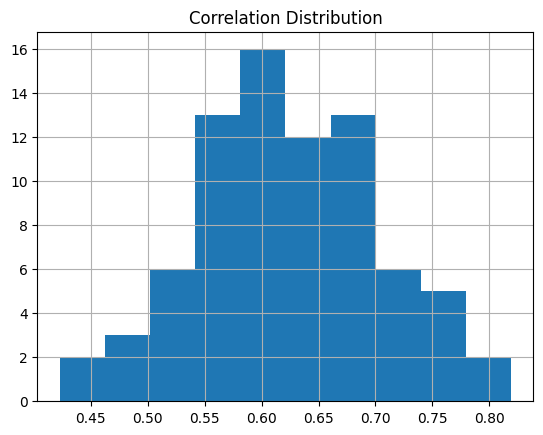

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [55]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train),
                               index=Xa_train.index,
                               columns=model_names).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [56]:
#MIN_SCORE3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

Min_score: 0.725


[['rforest'],
 ['gb'],
 ['xgb'],
 ['knn', 'lr', 'svm_linear'],
 ['sgd', 'mlp', 'lr'],
 ['sgd', 'lr', 'svm_linear'],
 ['adab'],
 ['svm_rbf', 'svm_linear'],
 ['kan'],
 ['svm_poly'],
 ['dtree']]

Conjunto de Teste:

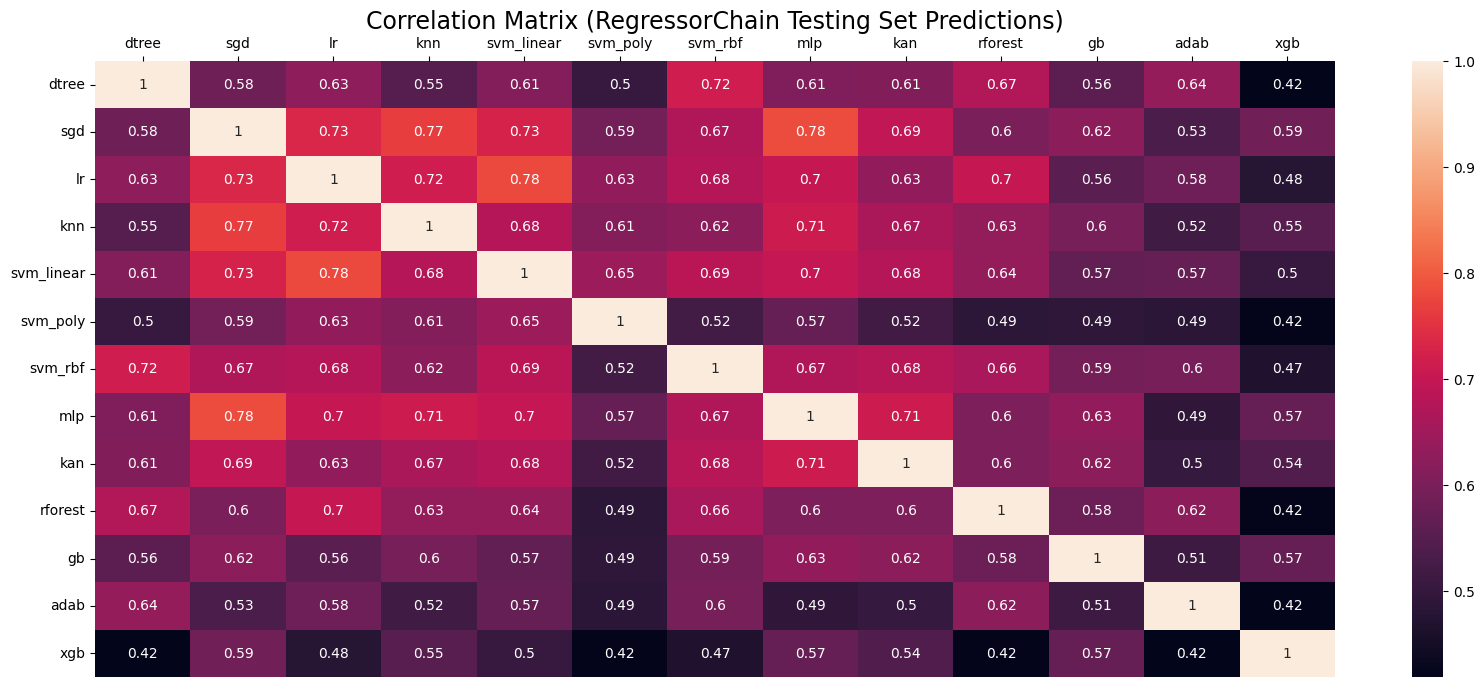

count    78.000000
mean      0.602761
std       0.086044
min       0.419136
25%       0.551474
50%       0.605247
75%       0.670988
max       0.783951
Name: corr, dtype: float64


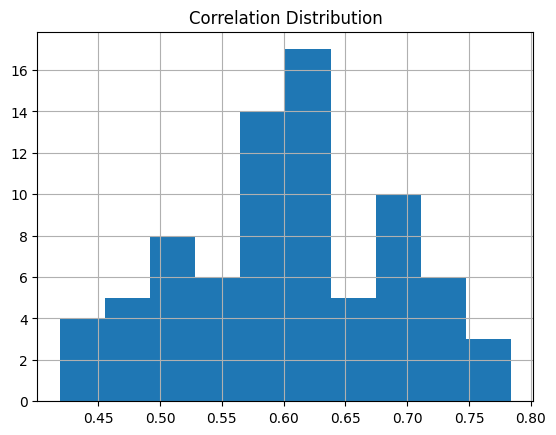

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [57]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test),
                               columns=model_names,
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [58]:
#MIN_SCORE3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

Min_score: 0.725


[['rforest'],
 ['knn', 'sgd'],
 ['sgd', 'mlp'],
 ['sgd', 'lr', 'svm_linear'],
 ['gb'],
 ['xgb'],
 ['adab'],
 ['svm_rbf'],
 ['kan'],
 ['svm_poly'],
 ['dtree']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4905
MAE: 0.6696
NMSE: 29.5055
NMAE: 7.1310


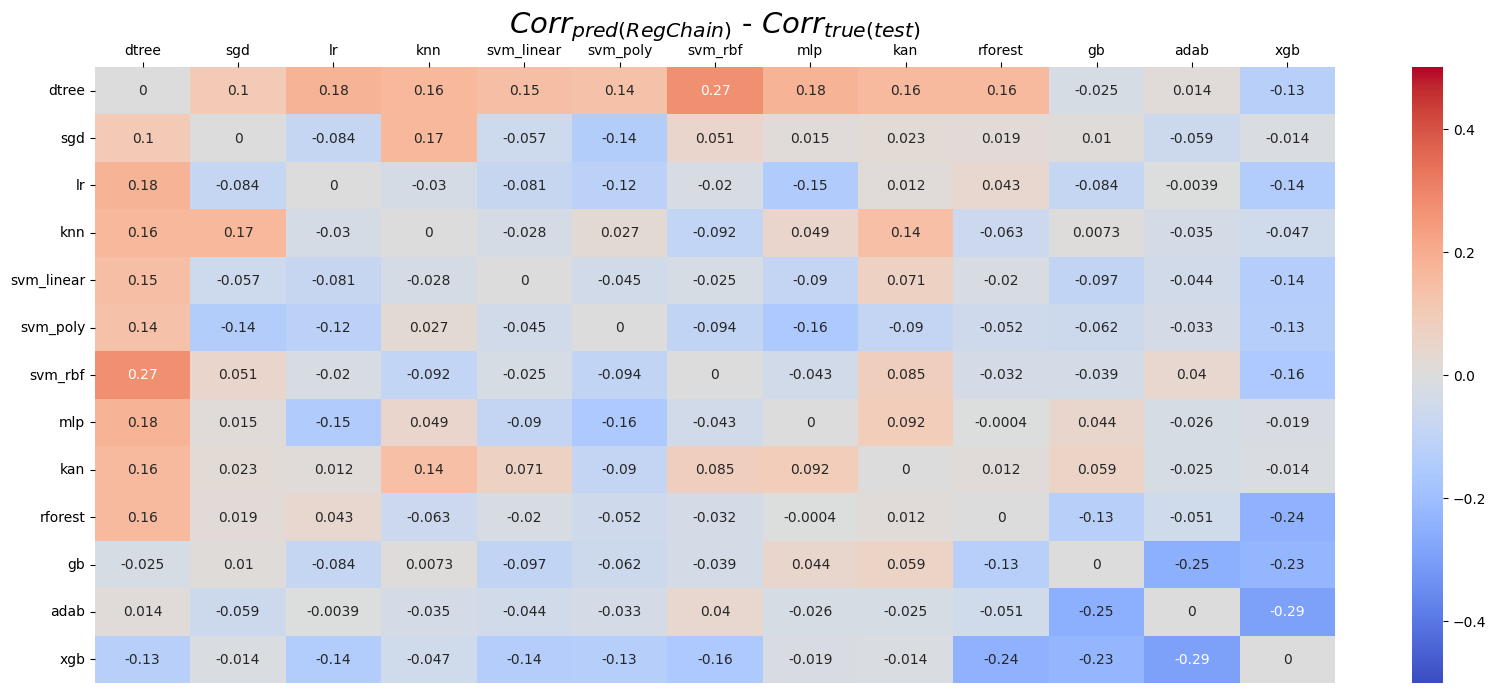

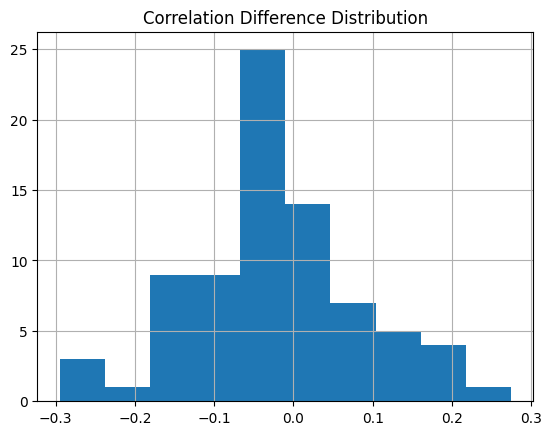

[Saved image "cmd_rc.eps"]
[Saved image "cdd_rc.eps"]


In [59]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output Random Forest Regressor

In [60]:
mrf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train)

In [61]:
ya_pred = mrf.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-rforest',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-rforest',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0705
NMSE: 1.0739
MAE: 0.2006
NMAE: 0.9677


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-rforest  0.101997  0.095020  0.047279  0.050046    0.055701  0.051444   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-rforest  0.061127  0.079850  0.152141  0.046816  0.057553  0.014460   

                    xgb  
regchain       0.105586  
multi-rforest  0.102614

#### Análise das correlações

Conjunto de Treinamento:

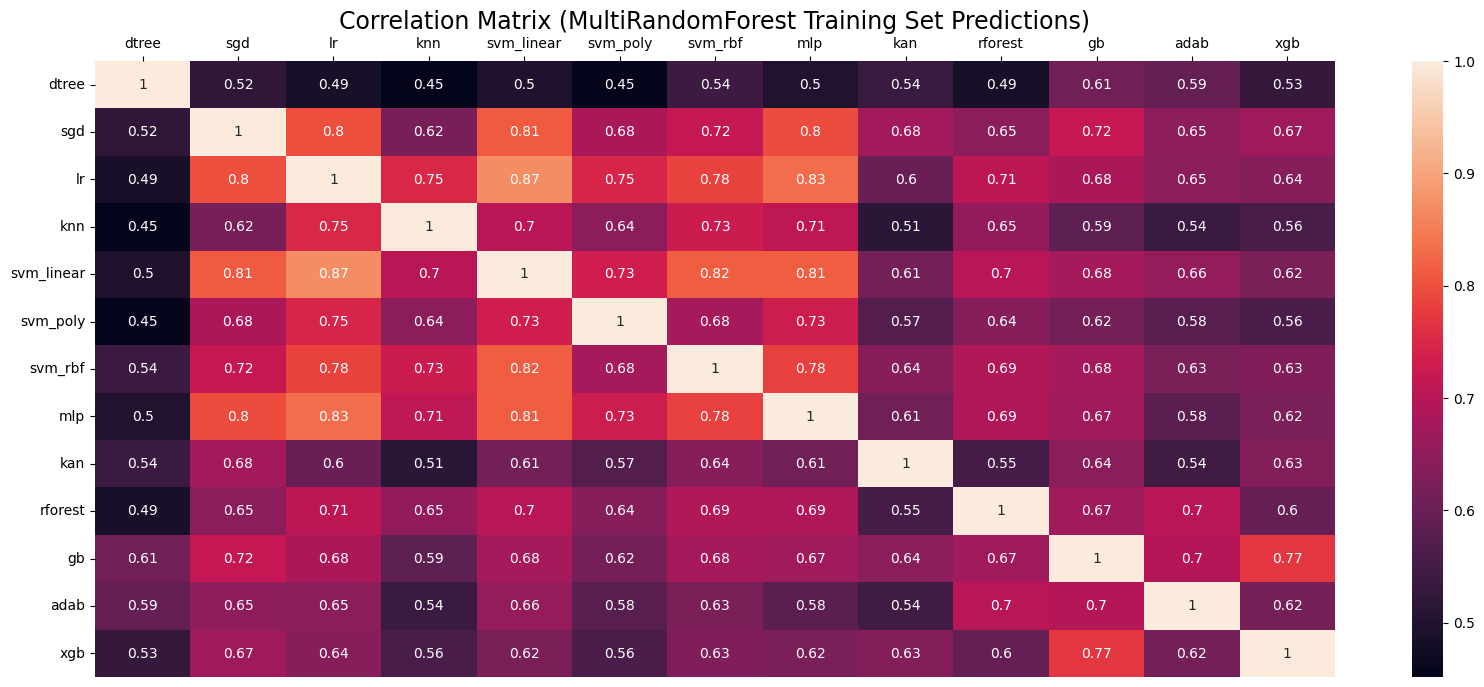

count    78.000000
mean      0.647491
std       0.093284
min       0.451562
25%       0.587563
50%       0.644493
75%       0.702243
max       0.869653
Name: corr, dtype: float64


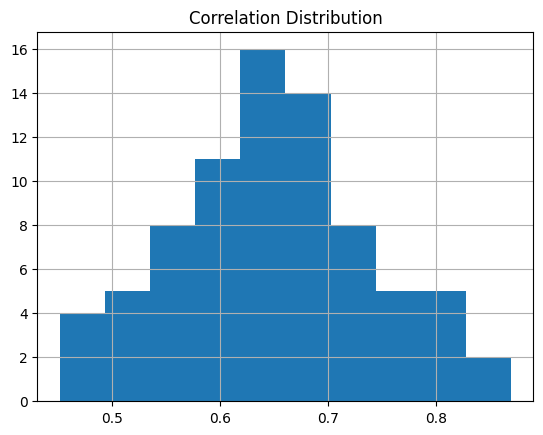

[Saved image "cm_mrftrain.eps"]
[Saved image "cd_mrftrain.eps"]


In [62]:
mrf_corrls = pd.DataFrame(mrf.predict(Xa_train),
                          columns=model_names,
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [63]:
groups['mrf_assessor_train'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_train']

[['rforest'],
 ['gb', 'xgb'],
 ['knn', 'svm_rbf', 'lr'],
 ['mlp', 'lr', 'sgd', 'svm_linear'],
 ['mlp', 'svm_rbf', 'lr', 'svm_linear'],
 ['mlp', 'lr', 'svm_poly', 'svm_linear'],
 ['adab'],
 ['kan'],
 ['dtree']]

Conjunto de Teste:

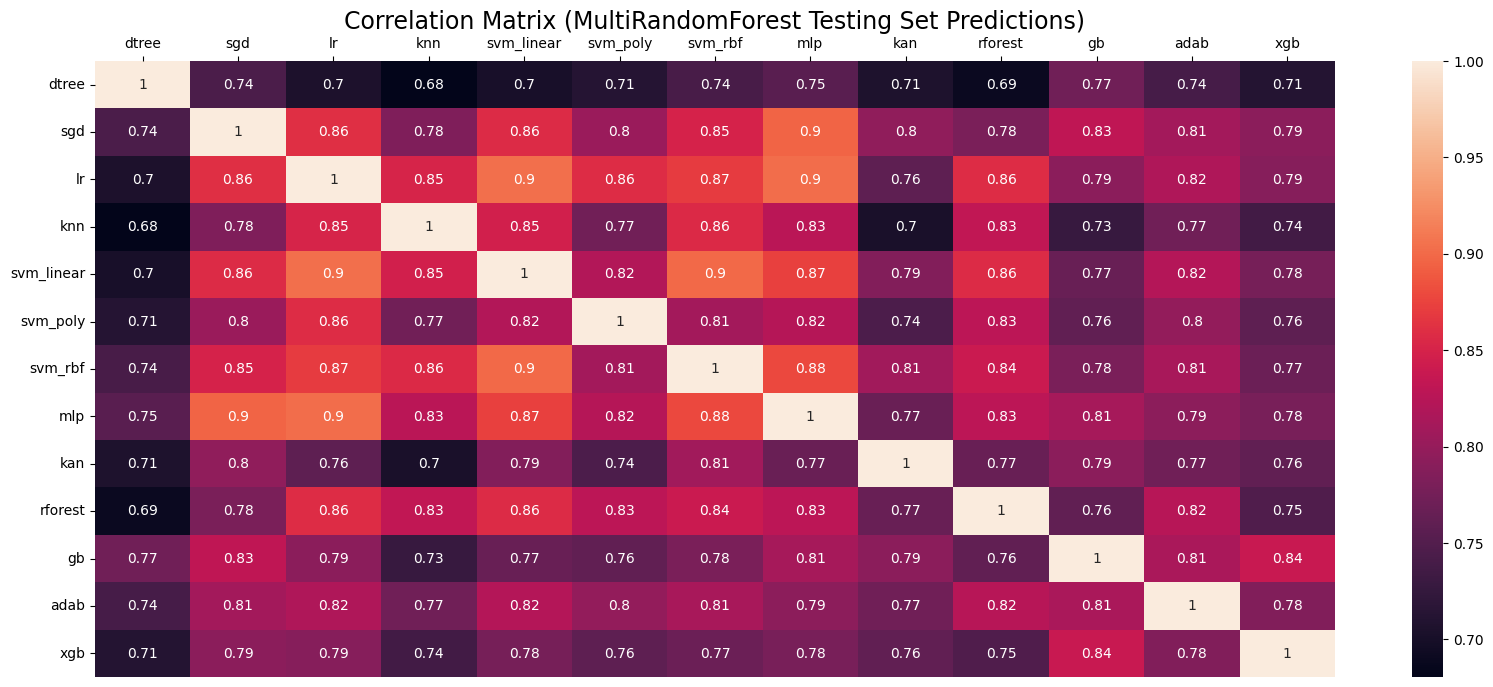

count    78.000000
mean      0.795368
std       0.053293
min       0.680457
25%       0.761111
50%       0.792593
75%       0.829784
max       0.903704
Name: corr, dtype: float64


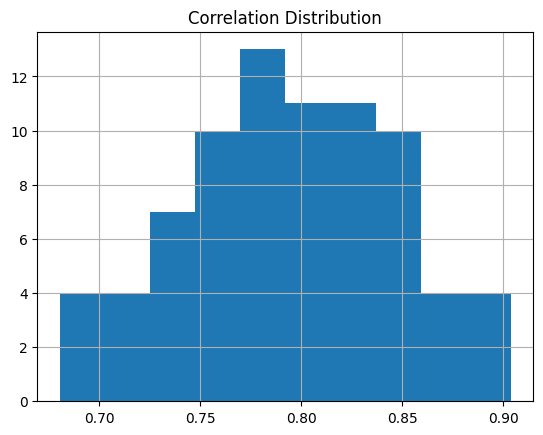

[Saved image "cm_mrftest.eps"]
[Saved image "cd_mrftest.eps"]


In [64]:
mrf_corrls = pd.DataFrame(ya_pred,
                          columns=model_names,
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [65]:
groups['mrf_assessor_test'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_test']

[['knn',
  'sgd',
  'rforest',
  'gb',
  'lr',
  'xgb',
  'mlp',
  'adab',
  'svm_rbf',
  'svm_linear',
  'svm_poly'],
 ['rforest',
  'sgd',
  'gb',
  'lr',
  'xgb',
  'mlp',
  'adab',
  'svm_rbf',
  'svm_linear',
  'kan',
  'svm_poly'],
 ['sgd', 'gb', 'adab', 'mlp', 'svm_rbf', 'dtree']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2887
MAE: 0.4918
NMSE: 17.2655
NMAE: 5.2332


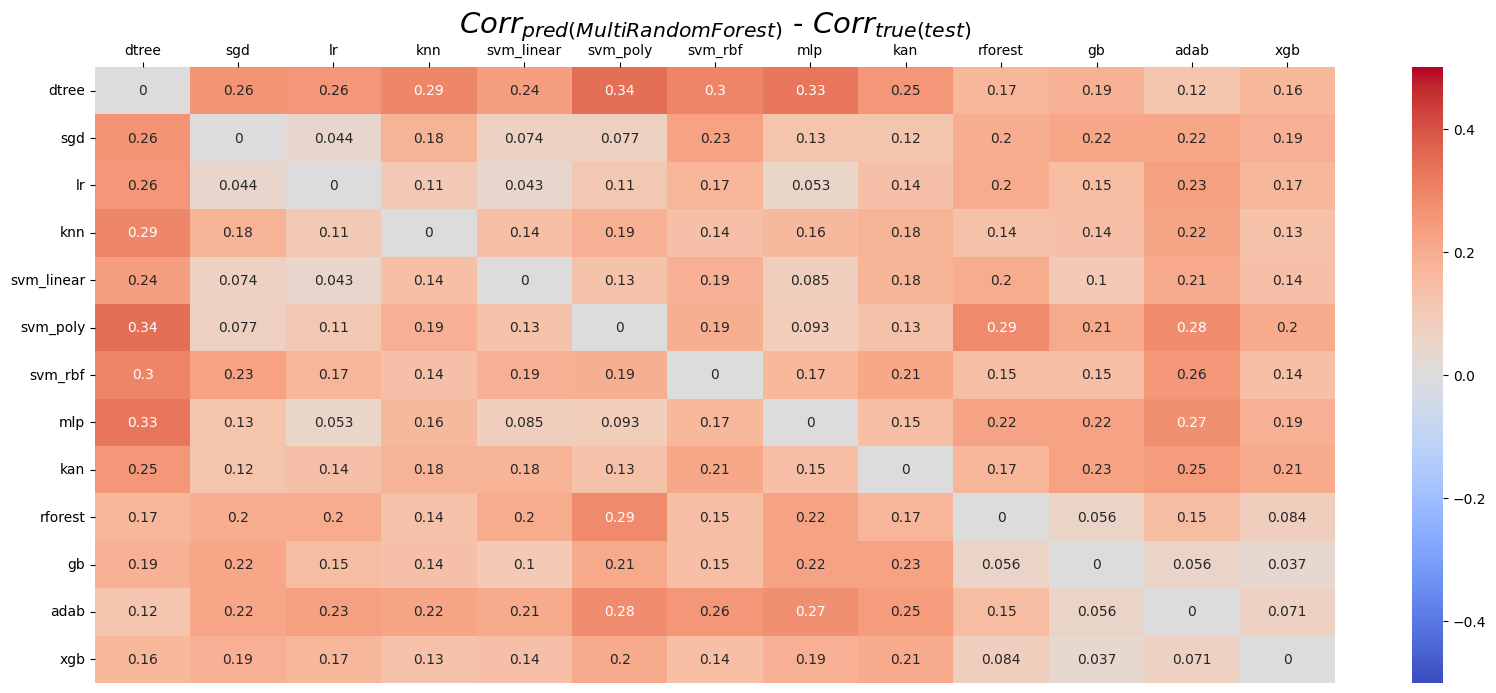

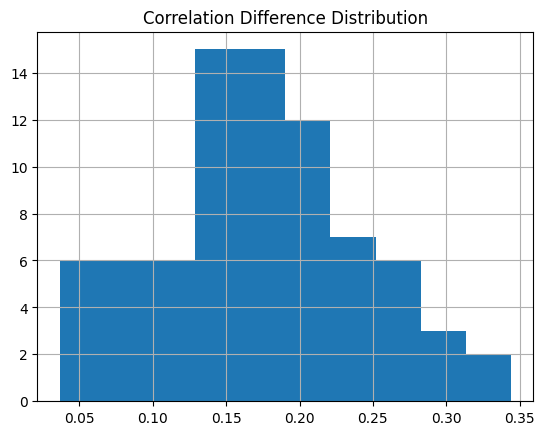

[Saved image "cmd_mrf.eps"]
[Saved image "cdd_mrf.eps"]


In [66]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mrf_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandomForest)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output SVR

In [67]:
from MSVR import MSVR

msvr = MSVR()
msvr.fit(np.asarray(Xb_test_norm), np.asarray(ya_train))

In [68]:
ya_pred = msvr.predict(Xa_test_norm)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-svr',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-svr',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-svr',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-svr',:] = nmae(ya_test, ya_pred, multioutput='raw_values')

MSE: 0.0579
MAE: 0.1756
NMSE: 0.8842
NMAE: 0.8479


count    78.000000
mean      0.658518
std       0.100052
min       0.455767
25%       0.593057
50%       0.663830
75%       0.729003
max       0.871892
Name: corr, dtype: float64


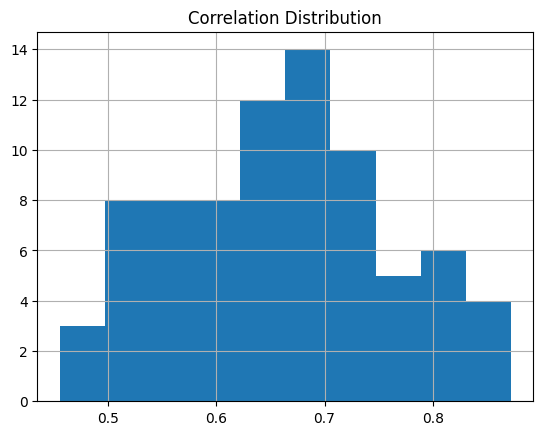

[Saved image "cm_msvrtrain.eps"]
[Saved image "cd_msvrtrain.eps"]


In [69]:
msvr_corrls = pd.DataFrame(msvr.predict(Xb_test_norm),
                          columns=model_names,
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Training Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [70]:
groups['msvr_assessor_train'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_train']

[['gb', 'xgb'],
 ['knn', 'svm_rbf', 'lr'],
 ['rforest', 'lr', 'svm_rbf', 'svm_linear'],
 ['sgd', 'lr', 'mlp', 'svm_rbf', 'svm_linear', 'svm_poly'],
 ['adab'],
 ['kan'],
 ['dtree']]

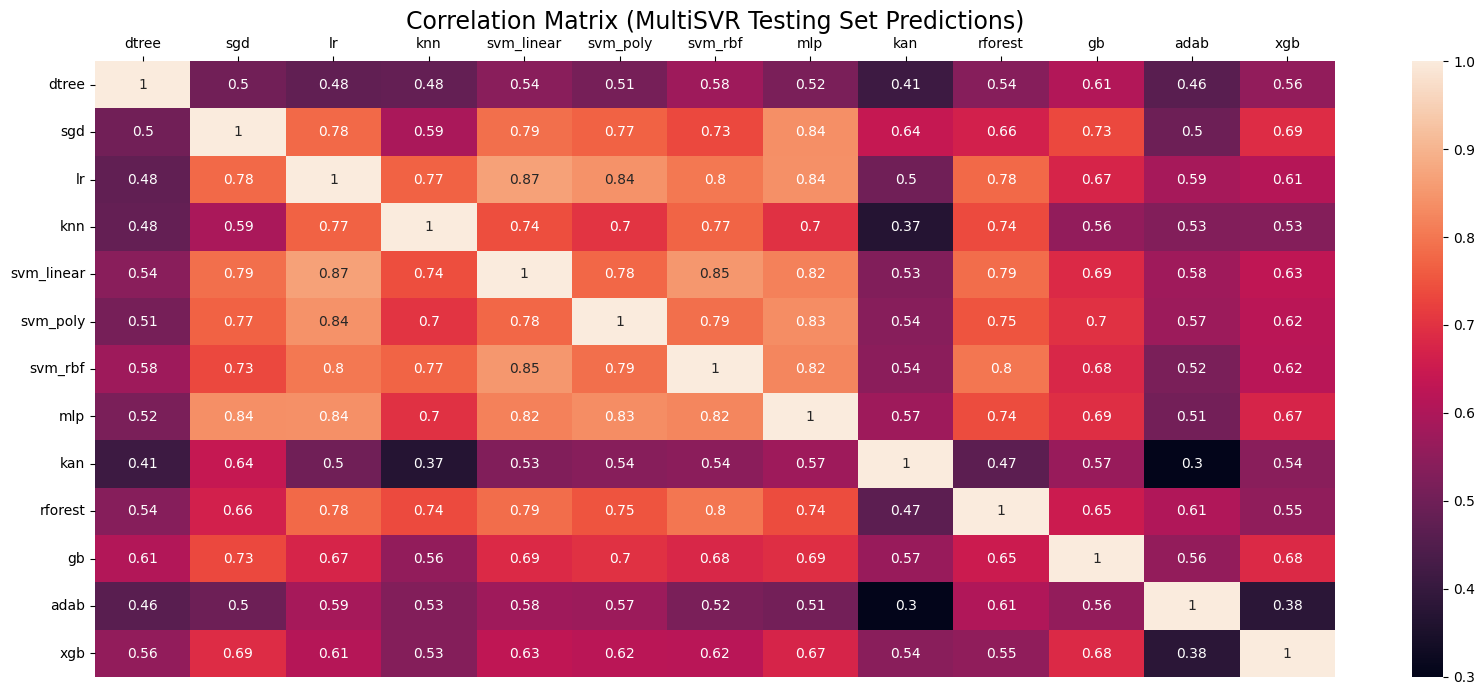

count    78.000000
mean      0.637591
std       0.130646
min       0.299383
25%       0.538426
50%       0.626235
75%       0.746914
max       0.867284
Name: corr, dtype: float64


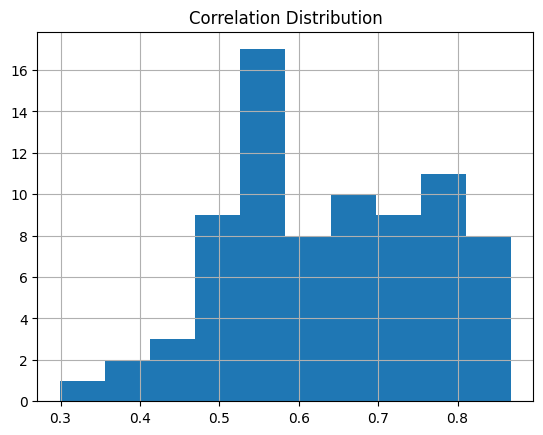

[Saved image "cm_msvrtest.eps"]
[Saved image "cd_msvrtest.eps"]


In [71]:
msvr_corrls = pd.DataFrame(ya_pred,
                          columns=model_names,
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4380
MAE: 0.6374
NMSE: 26.3237
NMAE: 6.8177


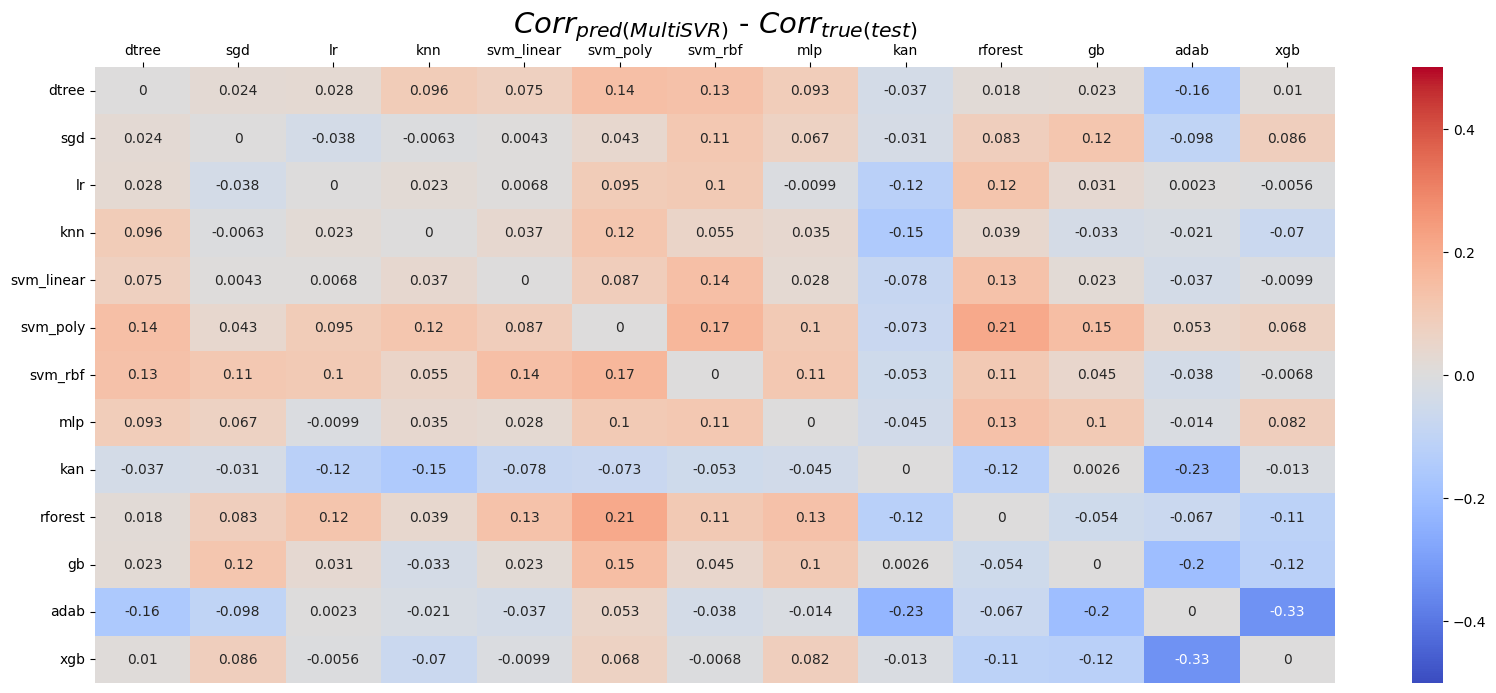

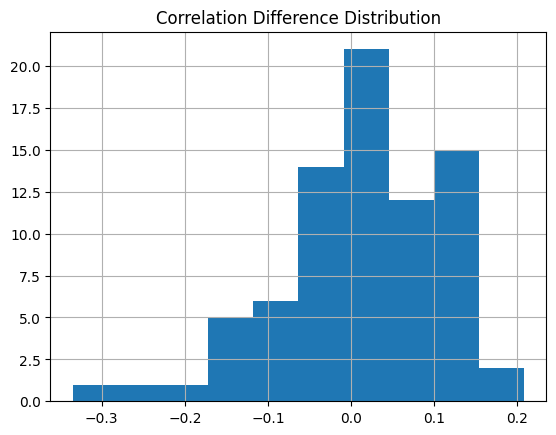

[Saved image "cmd_msvr.eps"]
[Saved image "cdd_msvr.eps"]


In [72]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = msvr_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVR)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [73]:
groups['msvr_assessor_test'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_test']

[['gb', 'sgd'],
 ['xgb'],
 ['rforest', 'knn', 'lr', 'svm_rbf', 'svm_linear'],
 ['rforest', 'lr', 'mlp', 'svm_rbf', 'svm_linear', 'svm_poly'],
 ['sgd', 'lr', 'mlp', 'svm_rbf', 'svm_linear', 'svm_poly'],
 ['adab'],
 ['kan'],
 ['dtree']]

### Multi-Output Regressor
(ST)

In [74]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [75]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-output',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-output',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-output',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0695
RMSE: 0.2546
MAE: 0.1973
NMAE: 0.9523


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-rforest  0.101997  0.095020  0.047279  0.050046    0.055701  0.051444   
multi-svr      0.100664  0.066706  0.031762  0.039831    0.036335  0.036822   
multi-output   0.091869  0.101041  0.046417  0.049038    0.052488  0.048239   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-rforest  0.061127  0.079850  0.152141  0.046816  0.057553  0.014460   
multi-svr      0.050508  0.060586  0.135387  0.039373  0.049711  0.017785   
multi-output   0.057535  0.077597  0.165216  0.044409  0.053412  0.013986   

                    xgb  
regchain       0.105586  
multi-rforest  0.102614  
multi-svr      0.087261  
multi-output   0.101638

#### Análise das correlações

Conjunto de Treinamento:

count    78.000000
mean      0.602625
std       0.101848
min       0.379704
25%       0.537850
50%       0.604479
75%       0.678574
max       0.856663
Name: corr, dtype: float64


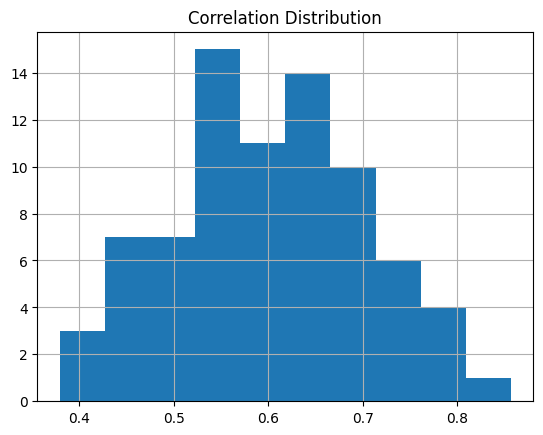

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [76]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train),
                          columns=model_names,
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [77]:
#MIN_SCORE4 = mor_corrls_values.quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

Min_score: 0.725


[['rforest'],
 ['gb'],
 ['xgb'],
 ['knn', 'lr'],
 ['mlp', 'lr', 'sgd', 'svm_linear'],
 ['mlp', 'svm_rbf', 'lr', 'svm_linear'],
 ['adab'],
 ['kan'],
 ['svm_poly'],
 ['dtree']]

Conjunto de Teste:

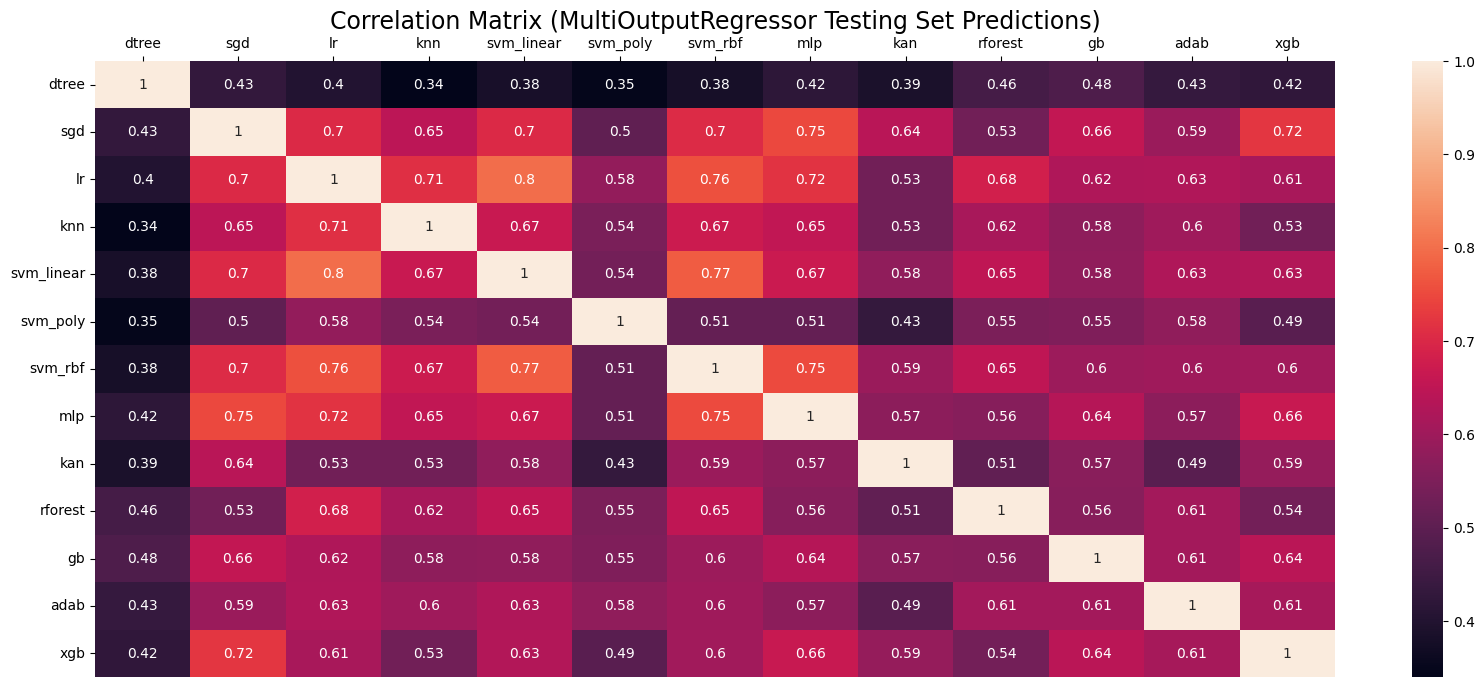

count    78.000000
mean      0.580411
std       0.103503
min       0.339867
25%       0.531481
50%       0.589506
75%       0.650256
max       0.797531
Name: corr, dtype: float64


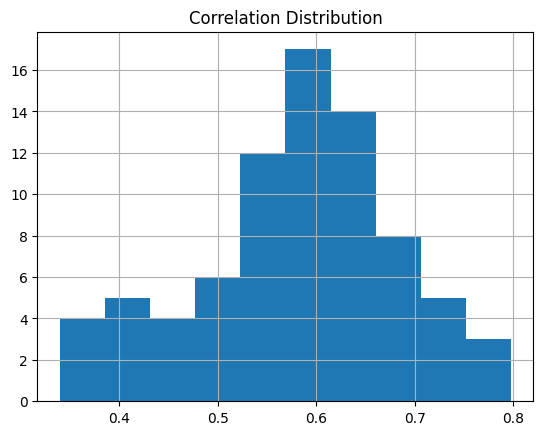

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [78]:
mor_corrls = pd.DataFrame(ya_pred,
                          columns=model_names,
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [79]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['knn'],
 ['sgd', 'mlp'],
 ['rforest'],
 ['gb'],
 ['xgb'],
 ['adab'],
 ['mlp', 'svm_rbf'],
 ['lr', 'svm_rbf', 'svm_linear'],
 ['kan'],
 ['svm_poly'],
 ['dtree']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.5034
MAE: 0.6902
NMSE: 29.9243
NMAE: 7.3420


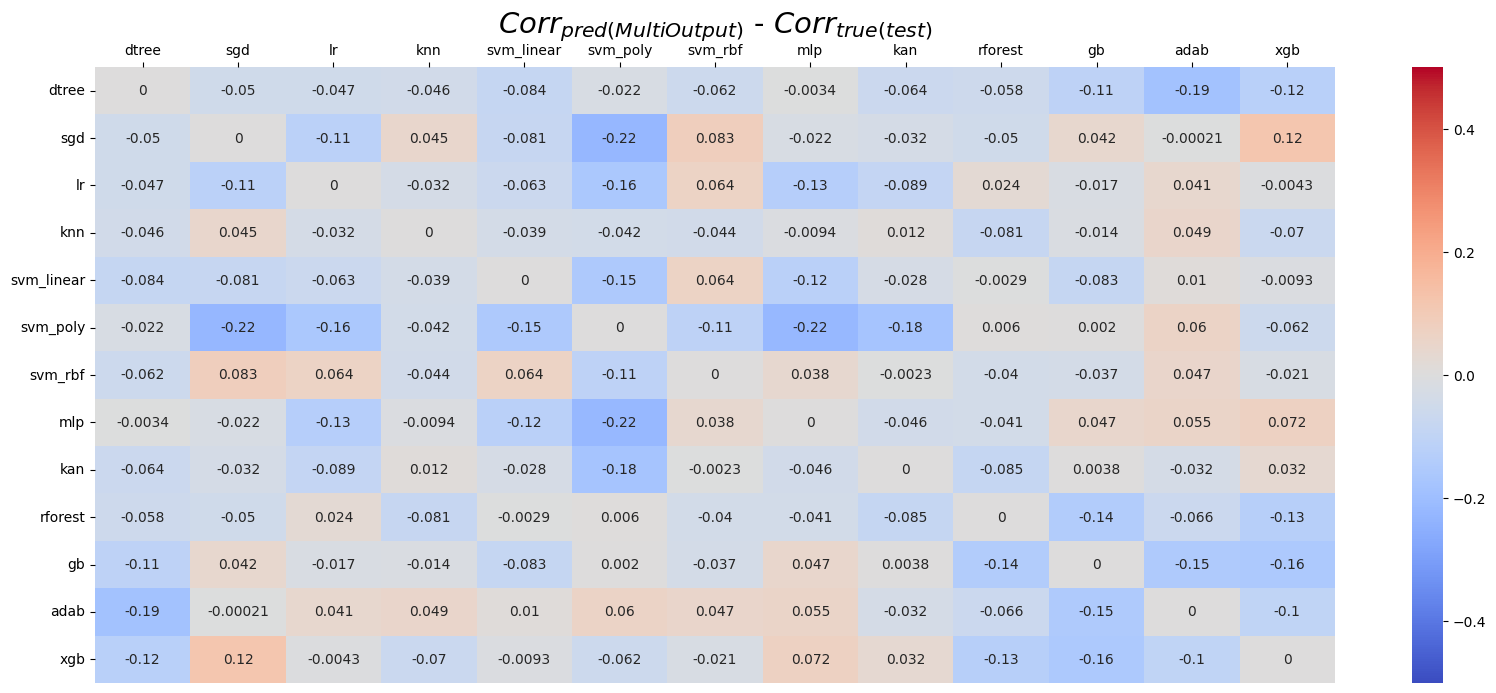

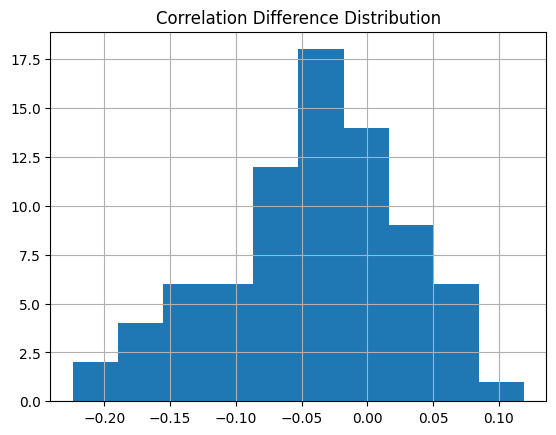

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [80]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Grupais

In [81]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(9) & true_assessor_test(9):
['rforest']
['gb', 'xgb']
['knn', 'lr']
['kan']
['dtree']
Número de grupos em comum: 5


true_assessor_train(9) & regchain_assessor_train(11):
['rforest']
['adab']
['kan']
['svm_poly']
['dtree']
Número de grupos em comum: 5


true_assessor_train(9) & regchain_assessor_test(11):
['rforest']
['adab']
['kan']
['svm_poly']
['dtree']
Número de grupos em comum: 5


true_assessor_train(9) & mrf_assessor_train(9):
['rforest']
['gb', 'xgb']
['mlp', 'lr', 'sgd', 'svm_linear']
['mlp', 'svm_rbf', 'lr', 'svm_linear']
['adab']
['kan']
['dtree']
Número de grupos em comum: 7


true_assessor_train(9) & mrf_assessor_test(3):
Número de grupos em comum: 0


true_assessor_train(9) & msvr_assessor_train(7):
['gb', 'xgb']
['adab']
['kan']
['dtree']
Número de grupos em comum: 4


true_assessor_train(9) & msvr_assessor_test(8):
['adab']
['kan']
['dtree']
Número de grupos em comum: 3


true_assessor_train(9) & mor_assessor_train(10):
['rforest']
['knn', 'lr']
['ml

In [82]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['gb', 'xgb']
total: 0.7666945943304602

['knn', 'lr']
total: 0.7392848039040564

['mlp', 'lr', 'sgd', 'svm_linear']
total: 0.7982829413960432

['mlp', 'svm_rbf', 'lr', 'svm_linear']
total: 0.7994774169466218



### Regressor Chain

In [83]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [84]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0688
MAE: 0.1964
NMSE: 1.0349
NMAE: 0.9477


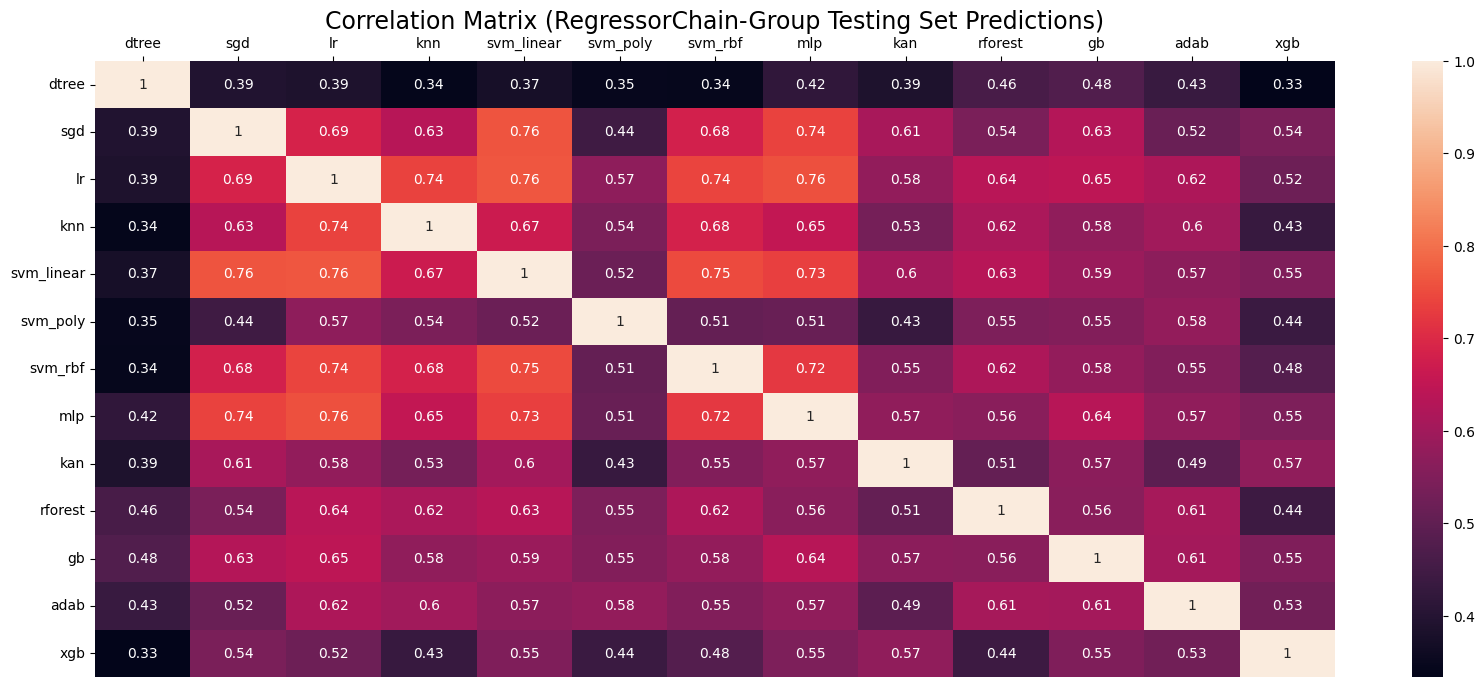

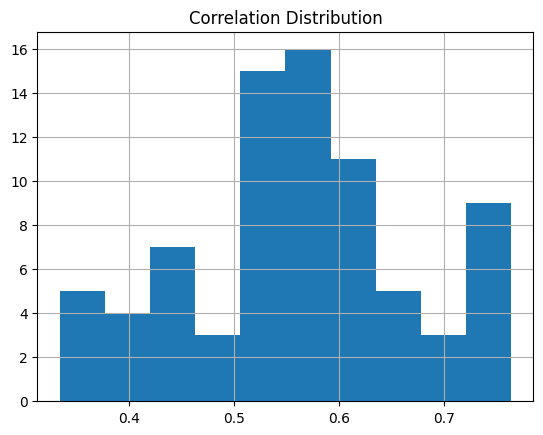

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.5286
MAE: 0.7087
NMSE: 31.5302
NMAE: 7.5447


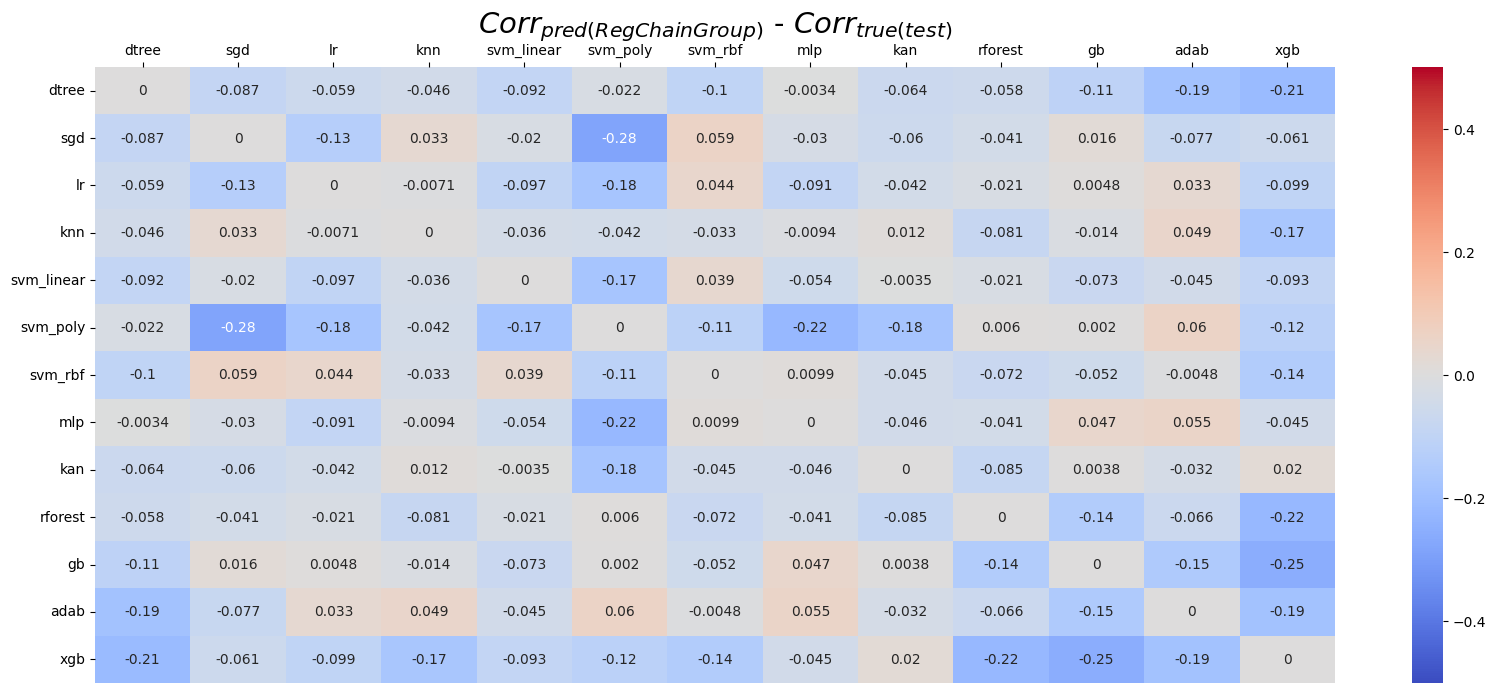

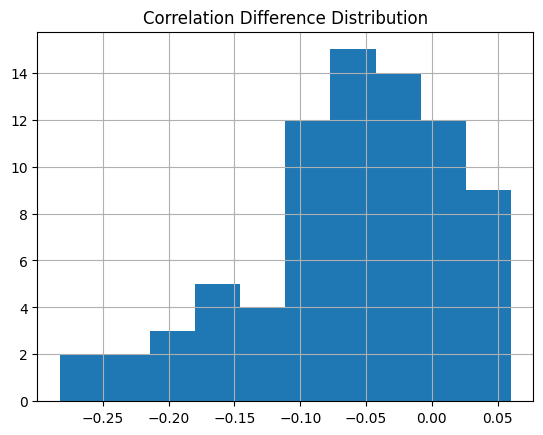

[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [85]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['regchain(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['regchain(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['regchain(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['regchain_group_test'] = group_search(regchainGroups_corrls, MIN_SCORE)

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Output SVR

In [86]:
msvr4groups = []

for g in groups['true_assessor_train']:
    msvr4groups.append(MSVR())
    msvr4groups[-1].fit(Xb_test_norm, np.asarray(ya_train[g]))

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:63: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


In [87]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = msvr4groups[i].predict(Xa_test_norm)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0633
MAE: 0.1786
NMSE: 0.9632
NMAE: 0.8659


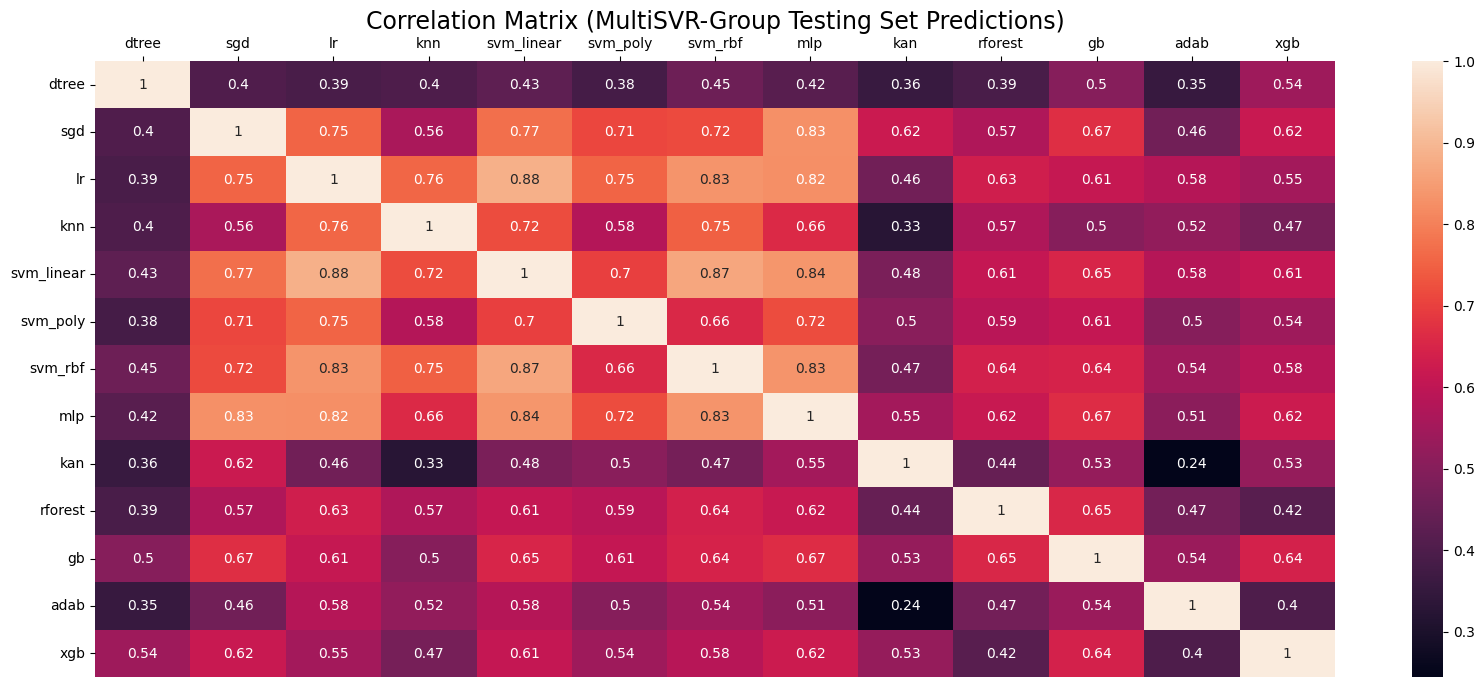

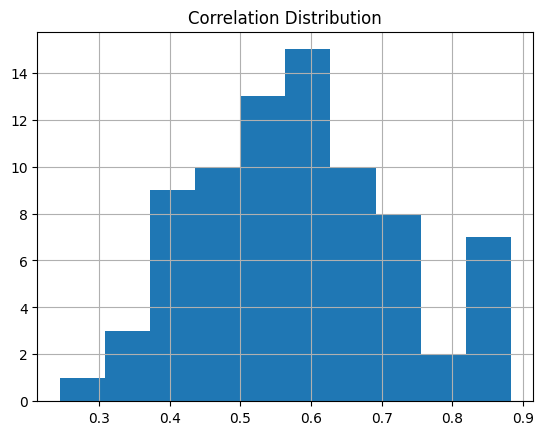

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.5011
MAE: 0.6904
NMSE: 30.1061
NMAE: 7.3886


[['rforest'], ['gb'], ['xgb'], ['knn', 'svm_rbf', 'lr'], ['mlp', 'lr', 'sgd', 'svm_linear'], ['mlp', 'svm_rbf', 'lr', 'svm_linear'], ['svm_poly', 'lr'], ['adab'], ['kan'], ['dtree']]
[Saved image "cm_msvrgtest.eps"]
[Saved image "cd_msvrgtest.eps"]
[Saved image "cmd_msvrg.eps"]
[Saved image "cdd_msvrg.eps"]


In [88]:
msvrGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-svr(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-svr(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-svr(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-svr(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(msvrGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(msvrGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = msvrGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVRGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['msvr_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)
print(groups['msvr_group_test'])

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Output Regressor

In [89]:
mrf4groups = []

for g in groups['true_assessor_train']:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train[g])
    mrf4groups.append(model)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [90]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mrf4groups[i].predict(Xa_test).reshape(-1,1) if len(g) == 1 else mrf4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0699
MAE: 0.1982
NMSE: 1.0547
NMAE: 0.9574


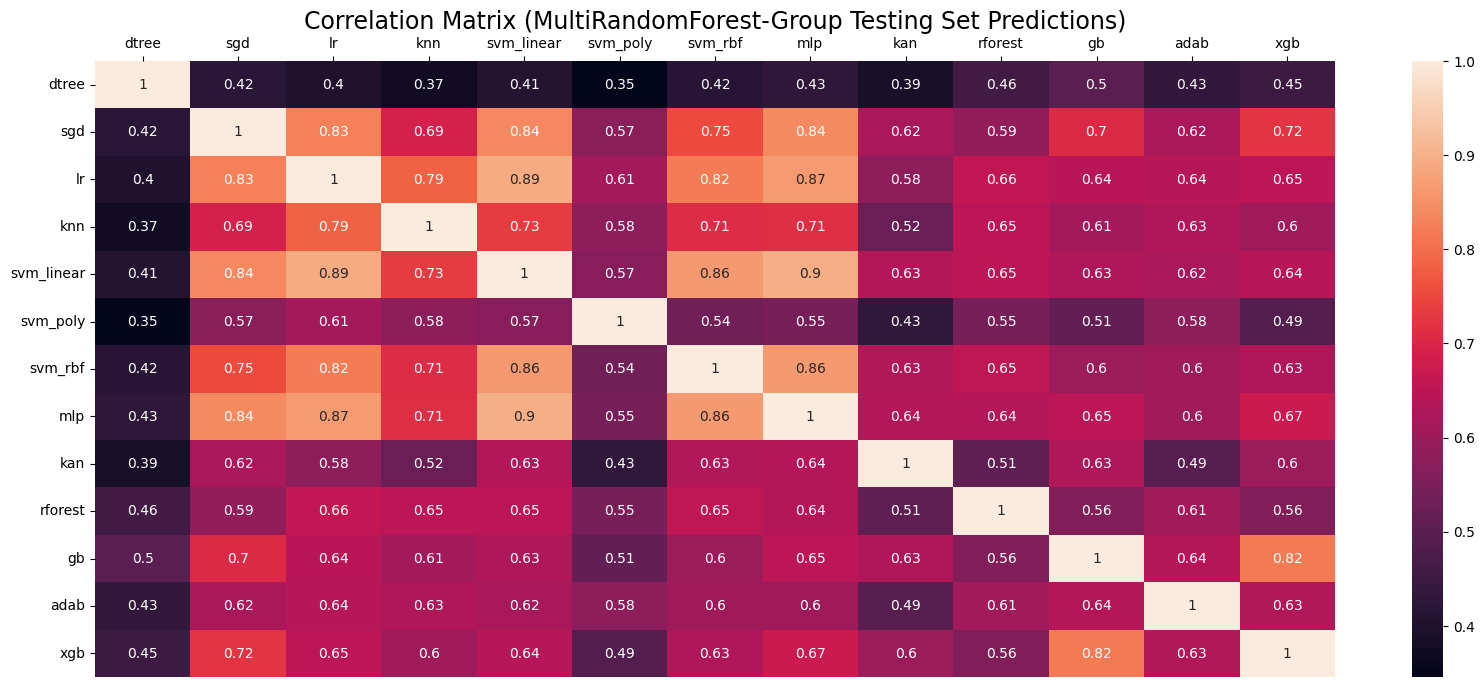

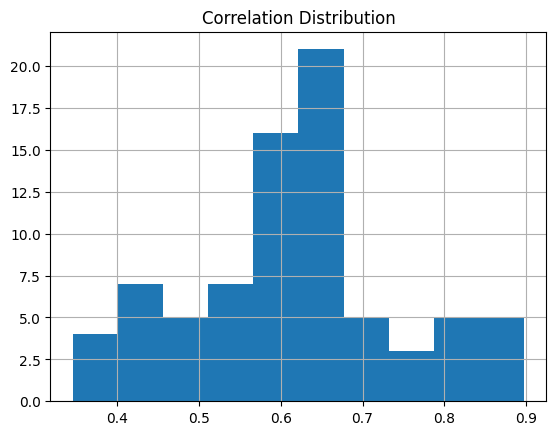

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4563
MAE: 0.6572
NMSE: 27.1706
NMAE: 7.0038


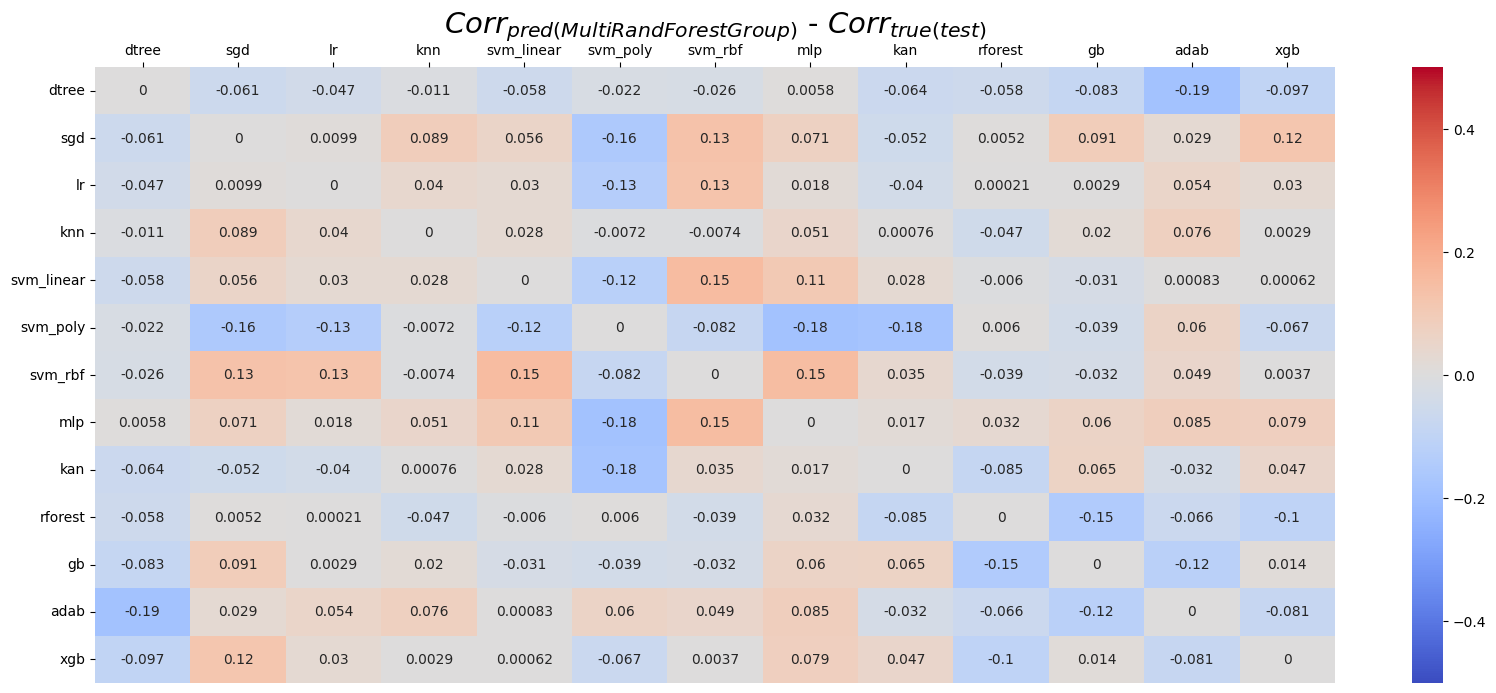

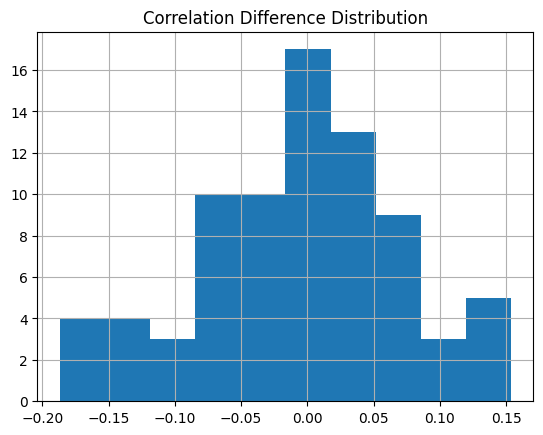

[['rforest'], ['gb'], ['xgb'], ['knn', 'svm_rbf', 'lr'], ['mlp', 'lr', 'sgd', 'svm_linear'], ['mlp', 'svm_rbf', 'lr', 'svm_linear'], ['svm_poly', 'lr'], ['adab'], ['kan'], ['dtree']]
[Saved image "cm_mrfgtest.eps"]
[Saved image "cd_mrfgtest.eps"]
[Saved image "cmd_mrfg.eps"]
[Saved image "cdd_mrfg.eps"]


In [91]:
mrfGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-rforest(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-rforest(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(mrfGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(mrfGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = mrfGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandForestGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['mrf_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)
print(groups['mrf_group_test'])

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

In [92]:
keys = list(groups.keys())
OBJV = len(groups['true_assessor_test'])
for i in range(len(keys)):
    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups['true_assessor_test']):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

regchain_assessor_test(11) & true_assessor_test(9):
['rforest']
['svm_rbf']
['kan']
['dtree']
Número de grupos em comum: 4


mrf_assessor_test(3) & true_assessor_test(9):
Número de grupos em comum: 0


msvr_assessor_test(8) & true_assessor_test(9):
['kan']
['dtree']
Número de grupos em comum: 2


mor_assessor_test(11) & true_assessor_test(9):
['rforest']
['kan']
['dtree']
Número de grupos em comum: 3


regchain_group_test(11) & true_assessor_test(9):
['rforest']
['knn', 'lr']
['kan']
['dtree']
Número de grupos em comum: 4


msvr_group_test(10) & true_assessor_test(9):
['rforest']
['kan']
['dtree']
Número de grupos em comum: 3


mrf_group_test(10) & true_assessor_test(9):
['rforest']
['kan']
['dtree']
Número de grupos em comum: 3




## Análises

In [93]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmae_df, 'NMAE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE       MAE      NMSE      NMAE
0               regchain  dtree  0.091869  0.227641  0.914335  0.807051
1          multi-rforest  dtree  0.101997  0.263886  1.015131  0.935548
2              multi-svr  dtree  0.100664  0.248854  1.001863  0.882256
3           multi-output  dtree  0.091869  0.227641  0.914335  0.807051
4        regchain(group)  dtree  0.091869  0.227641  0.914335  0.807051
..                   ...    ...       ...       ...       ...       ...
86             multi-svr    xgb  0.087261  0.214075  0.935215  0.864698
87          multi-output    xgb  0.101638  0.244208  1.089298  0.986410
88       regchain(group)    xgb  0.101625  0.247379  1.089153  0.999218
89      multi-svr(group)    xgb  0.088049  0.214907  0.943656  0.868057
90  multi-rforest(group)    xgb  0.103447  0.243100  1.108682  0.981937

[91 rows x 6 columns]

In [ ]:
teste= metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
teste.to_csv('data/heart/results.csv')
teste

In [ ]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["MSE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-svr           7
regchain(group)     2
regchain            2
multi-svr(group)    2
Name: count, dtype: int64

In [ ]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["MAE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-output            6
regchain(group)         2
multi-svr(group)        2
regchain                1
multi-rforest(group)    1
multi-svr               1
Name: count, dtype: int64

In [ ]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["NMSE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict()
best_assessors['assessor_type'].value_counts()

assessor_type
multi-svr           7
regchain(group)     2
regchain            2
multi-svr(group)    2
Name: count, dtype: int64

In [ ]:
best_assessors = metrics_df.loc[metrics_df.groupby("model")["NMAE"].idxmin(), ["model", "assessor_type", "MSE"]]
#best_assessors = best_assessors.set_index("model")["assessor_type"].to_dict
best_assessors['assessor_type'].value_counts()

assessor_type
multi-output            6
regchain(group)         2
multi-svr(group)        2
regchain                1
multi-rforest(group)    1
multi-svr               1
Name: count, dtype: int64

In [95]:
class_palette = sns.color_palette()[:7]

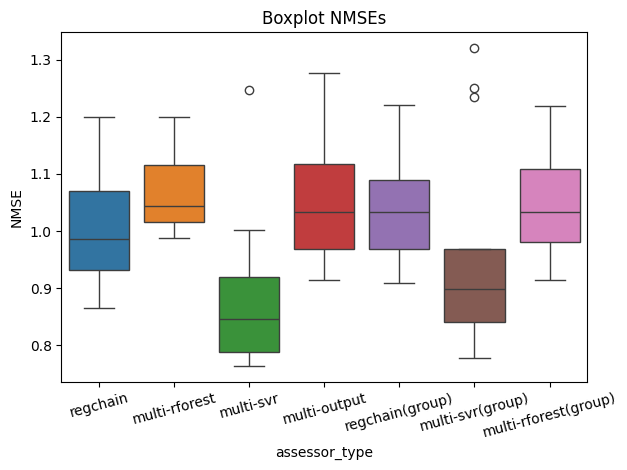

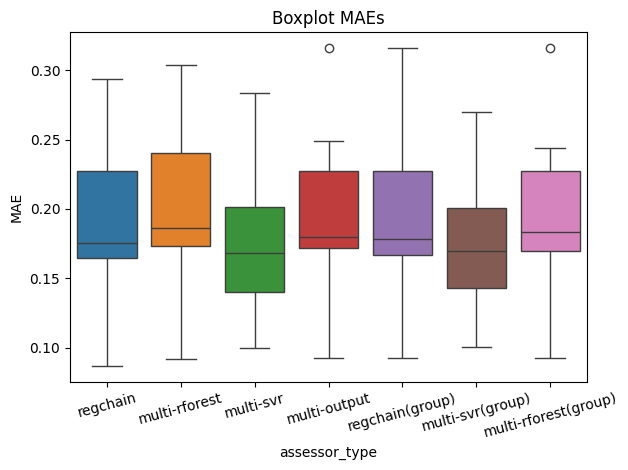

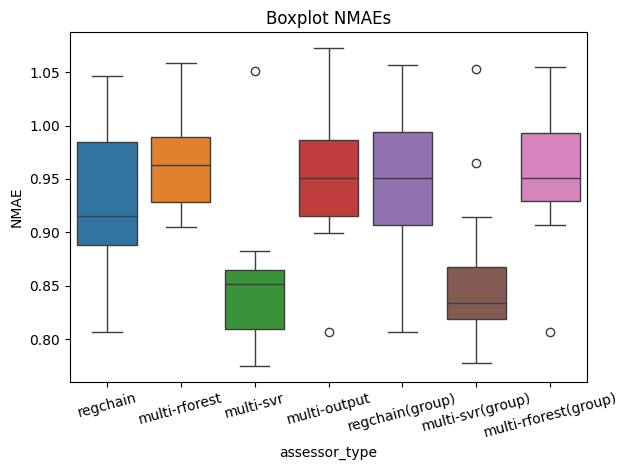

In [96]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


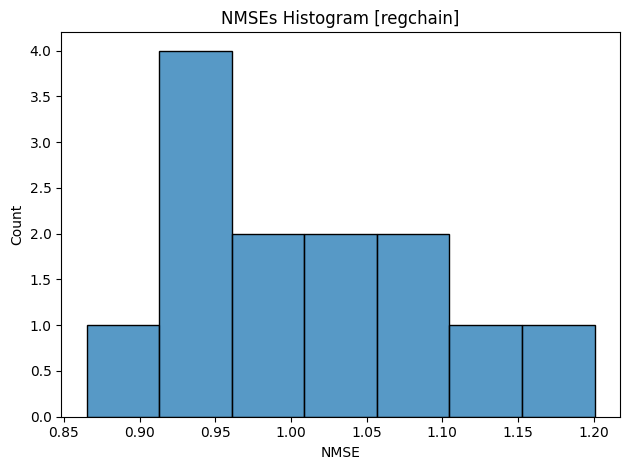

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


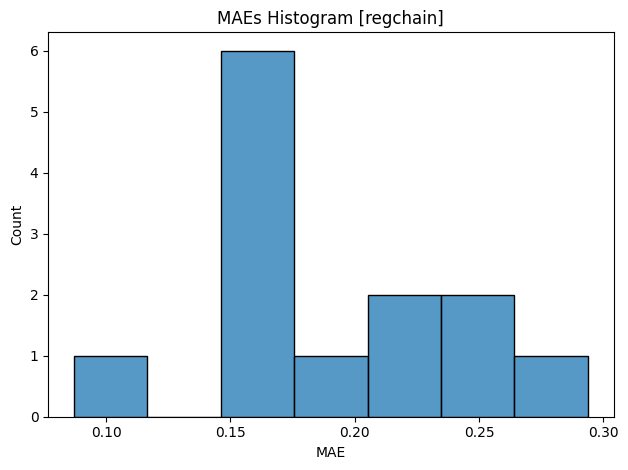

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


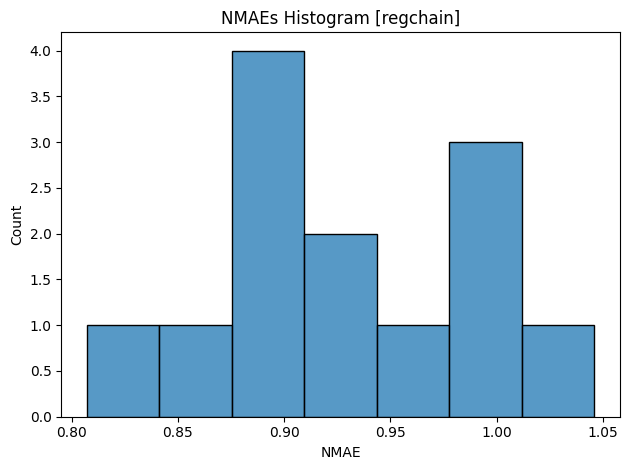

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


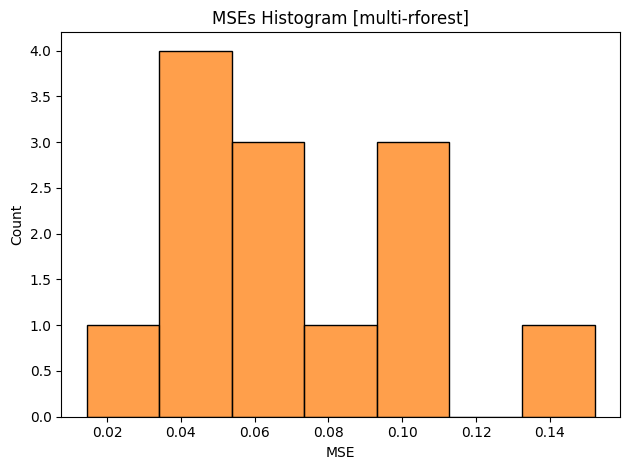

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


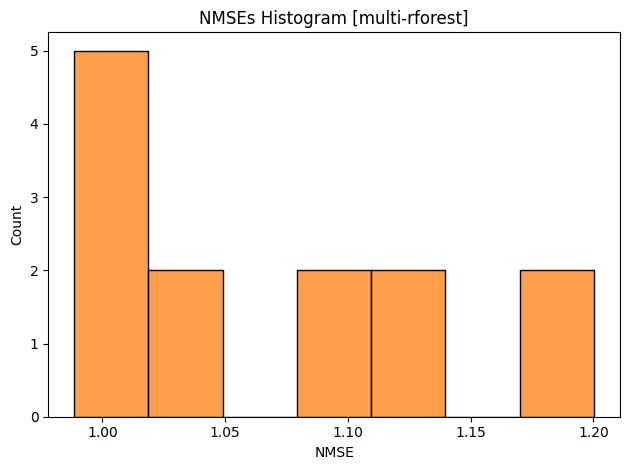

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


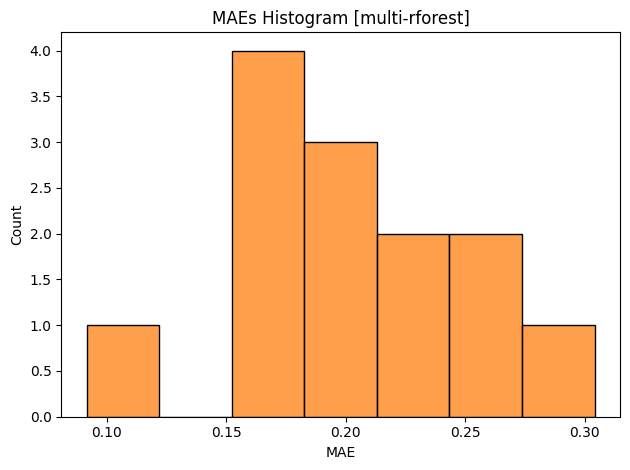

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


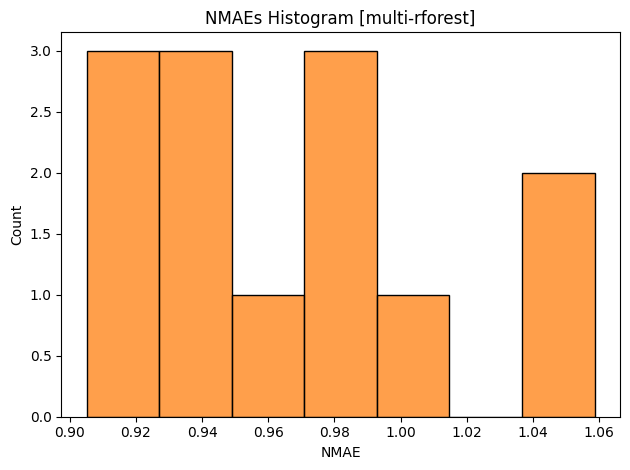

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


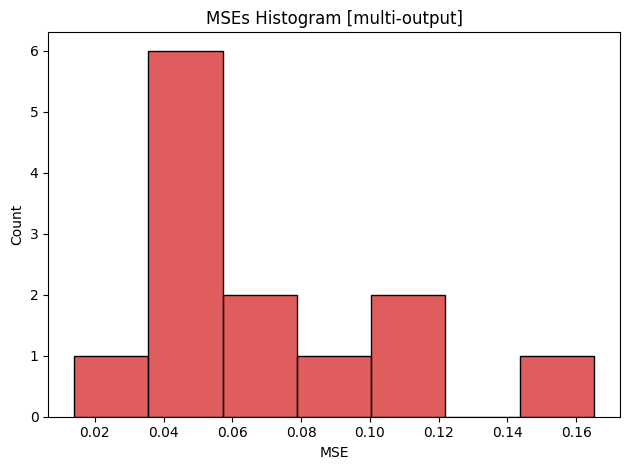

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


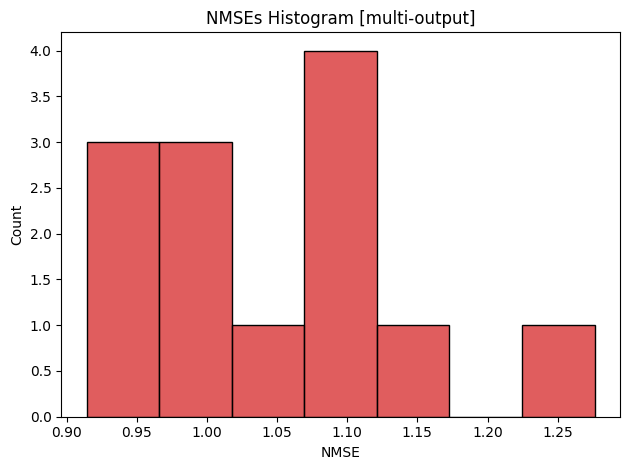

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


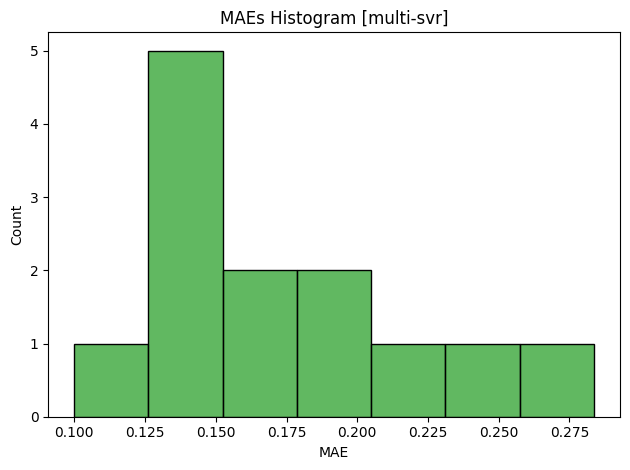

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


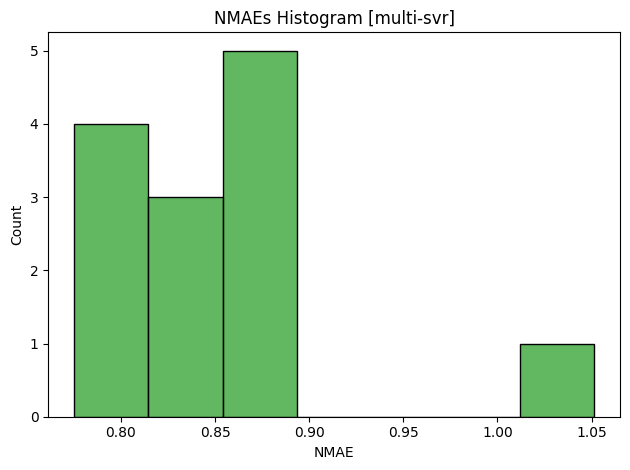

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


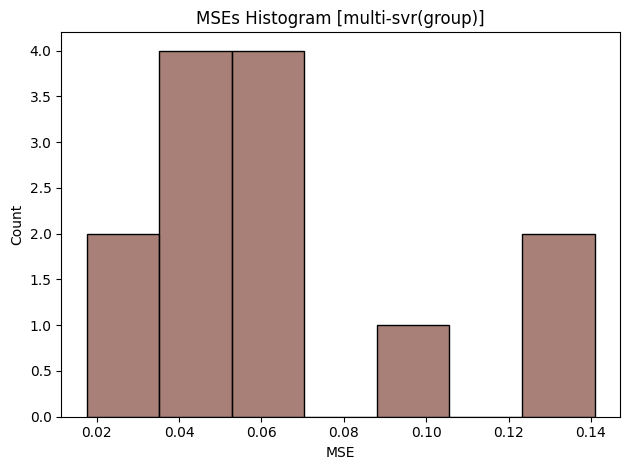

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


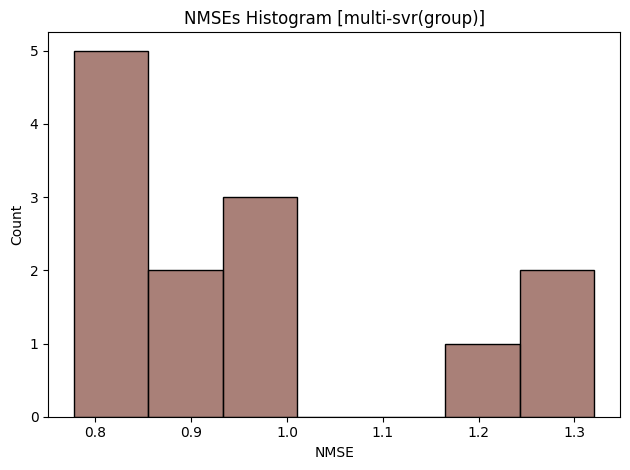

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


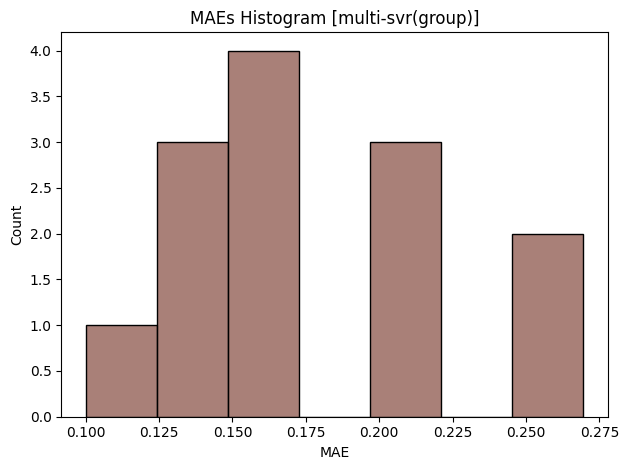

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


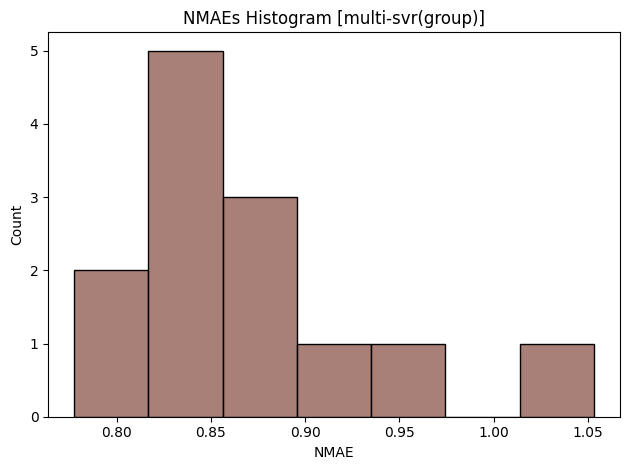

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


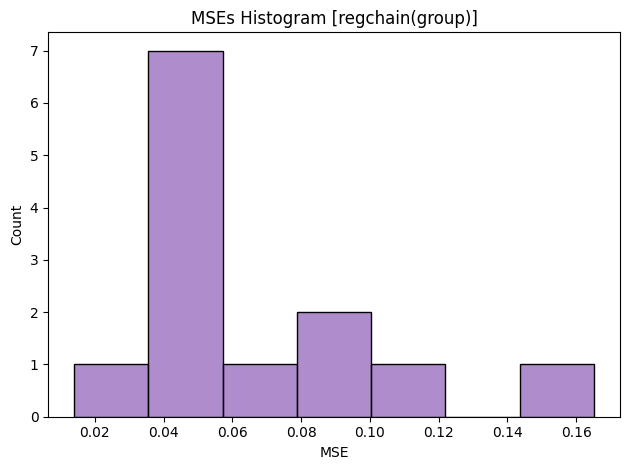

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


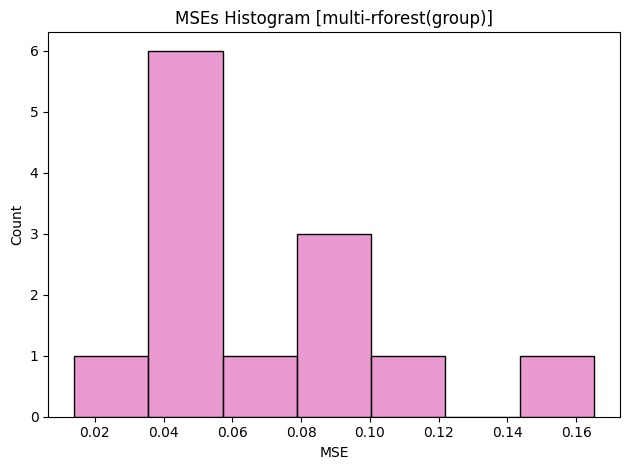

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


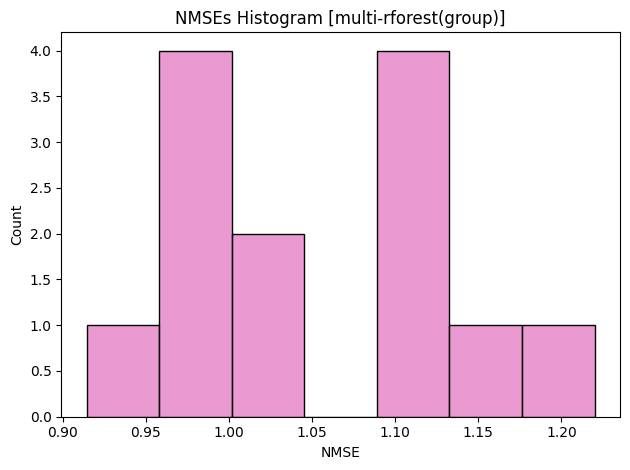

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


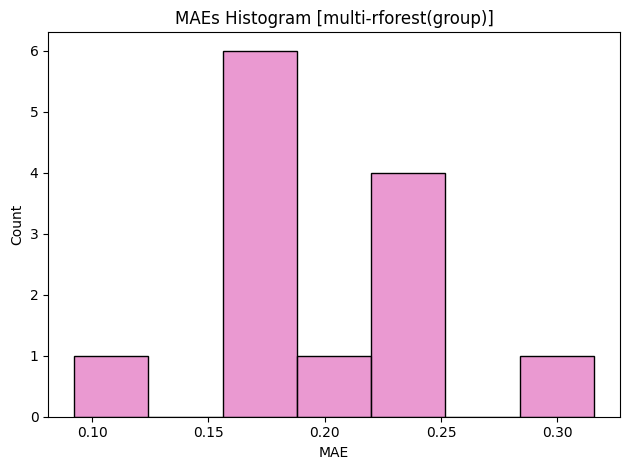

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


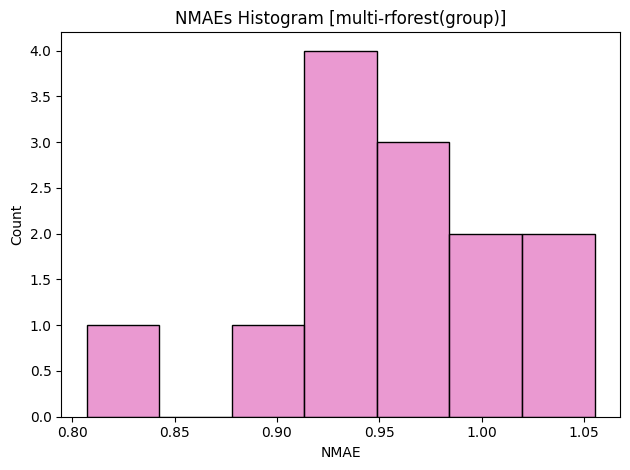

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [97]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-rforest': {'color': class_palette[1], 'code': 'mrf'},
         'multi-output': {'color': class_palette[3], 'code': 'mor'},
         'multi-svr': {'color': class_palette[2], 'code': 'msvr'},
         'multi-svr(group)': {'color': class_palette[-2], 'code': 'msvrg'},
         'regchain(group)': {'color': class_palette[-3], 'code': 'rcg'},
         'multi-rforest(group)': {'color': class_palette[-1], 'code': 'mrfg'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

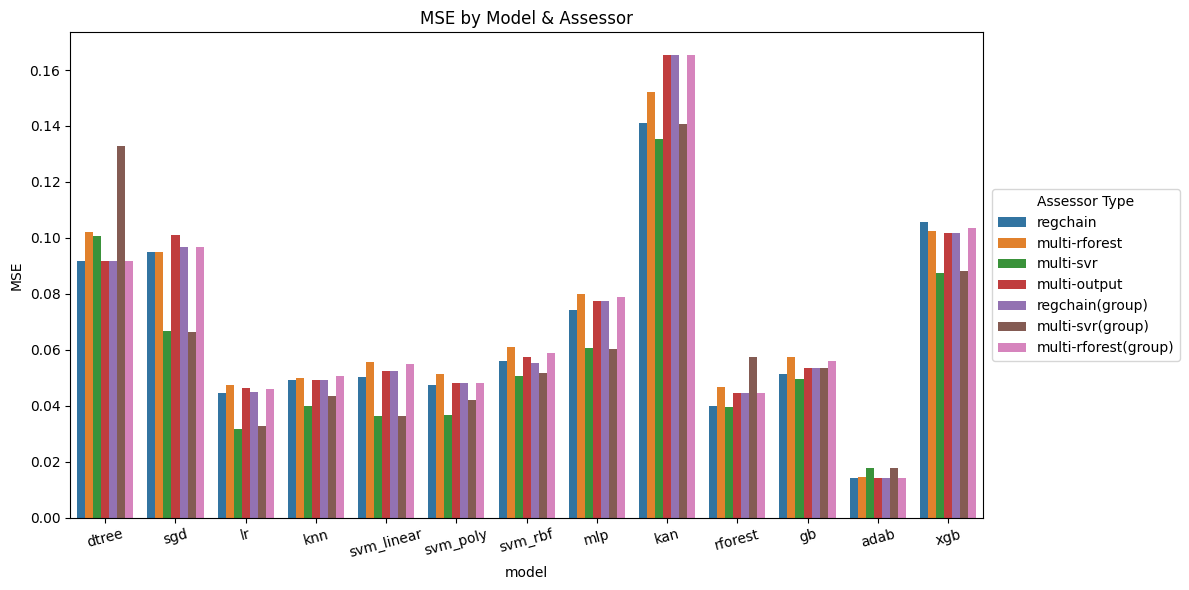

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


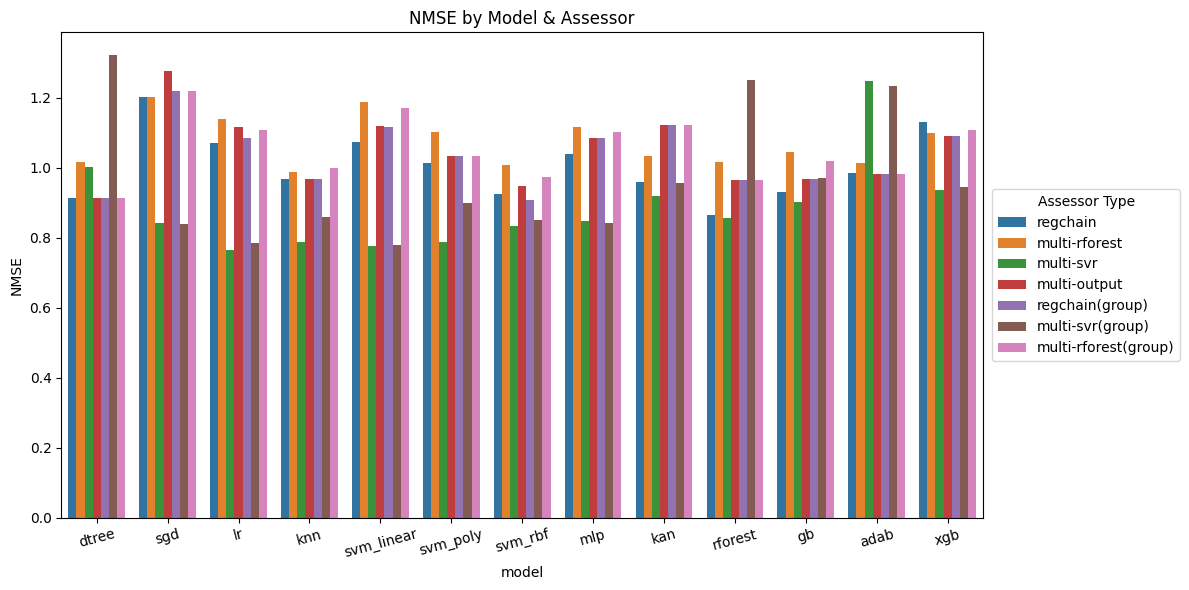

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


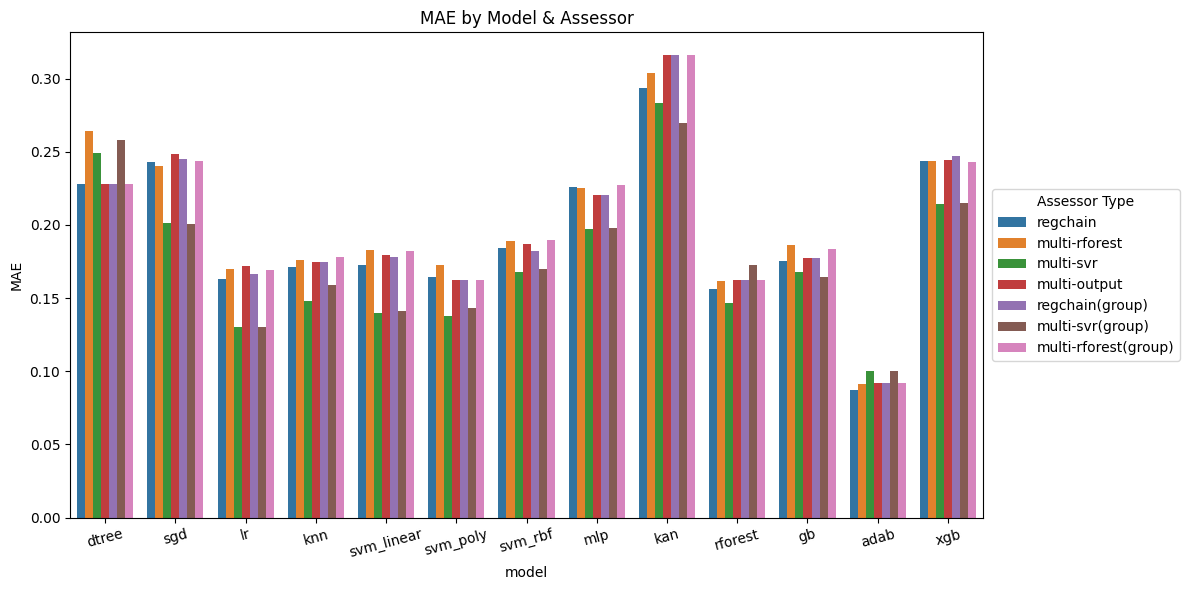

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


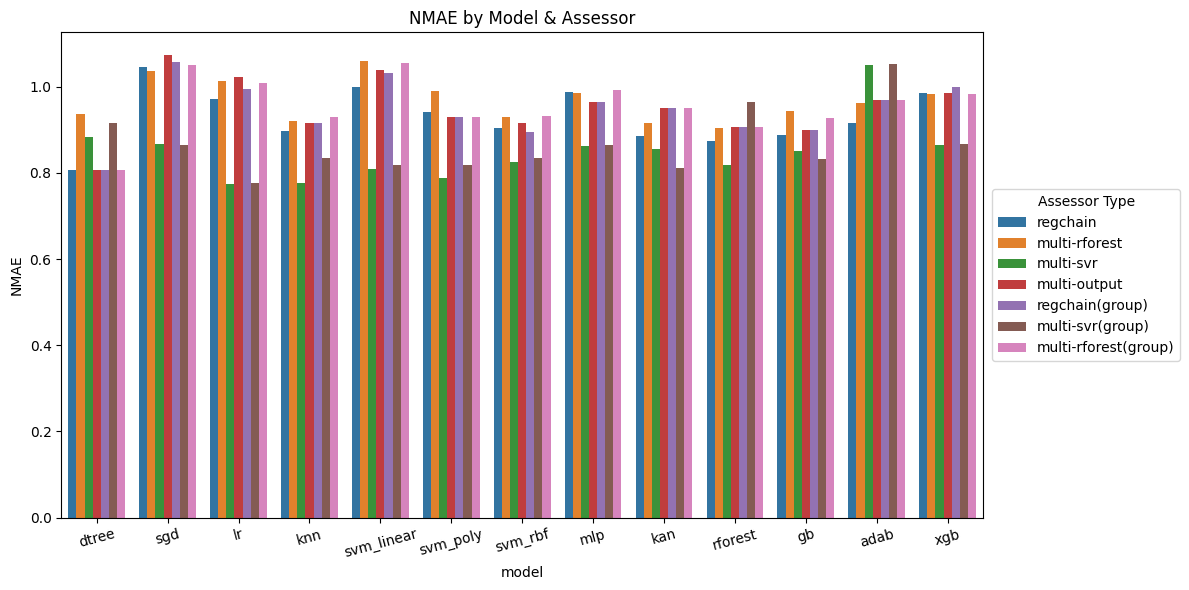

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [98]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)